# 引言
# 预备知识
# 线性神经网络

# 多层感知机

在本章中，我们将第一次介绍真正的*深度*网络。
最简单的深度网络称为*多层感知机*。多层感知机由多层神经元组成，
每一层与它的上一层相连，从中接收输入；
同时每一层也与它的下一层相连，影响当前层的神经元。
当我们训练容量较大的模型时，我们面临着*过拟合*的风险。
因此，本章将从基本的概念介绍开始讲起，包括*过拟合*、*欠拟合*和模型选择。
为了解决这些问题，本章将介绍*权重衰减*和*暂退法*等正则化技术。
我们还将讨论数值稳定性和参数初始化相关的问题，
这些问题是成功训练深度网络的关键。
在本章的最后，我们将把所介绍的内容应用到一个真实的案例：房价预测。
关于模型计算性能、可伸缩性和效率相关的问题，我们将放在后面的章节中讨论。

## 多层感知机

在[3节](./03.linear-networks.ipynb)中，
我们介绍了softmax回归([3.4节](./03.linear-networks.ipynb#softmax回归))，
然后我们从零开始实现了softmax回归([3.6节](./03.linear-networks.ipynb#softmax回归的从零开始实现))，
接着使用高级API实现了算法([3.7节](./03.linear-networks.ipynb#softmax回归的简洁实现))，
并训练分类器从低分辨率图像中识别10类服装。
在这个过程中，我们学习了如何处理数据，如何将输出转换为有效的概率分布，
并应用适当的损失函数，根据模型参数最小化损失。
我们已经在简单的线性模型背景下掌握了这些知识，
现在我们可以开始对深度神经网络的探索，这也是本书主要涉及的一类模型。

### 隐藏层

我们在[3.1.1.1节](./03.linear-networks.ipynb#线性模型)中描述了仿射变换，
它是一种带有偏置项的线性变换。
首先，回想一下如[图3.4.1](./03.linear-networks.ipynb#fig.3.4.1)中所示的softmax回归的模型架构。
该模型通过单个仿射变换将我们的输入直接映射到输出，然后进行softmax操作。
如果我们的标签通过仿射变换后确实与我们的输入数据相关，那么这种方法确实足够了。
但是，仿射变换中的*线性*是一个很强的假设。

#### 线性模型可能会出错

例如，线性意味着*单调*假设：
任何特征的增大都会导致模型输出的增大（如果对应的权重为正），
或者导致模型输出的减小（如果对应的权重为负）。
有时这是有道理的。
例如，如果我们试图预测一个人是否会偿还贷款。
我们可以认为，在其他条件不变的情况下，
收入较高的申请人比收入较低的申请人更有可能偿还贷款。
但是，虽然收入与还款概率存在单调性，但它们不是线性相关的。
收入从0增加到5万，可能比从100万增加到105万带来更大的还款可能性。
处理这一问题的一种方法是对我们的数据进行预处理，
使线性变得更合理，如使用收入的对数作为我们的特征。

然而我们可以很容易找出违反单调性的例子。
例如，我们想要根据体温预测死亡率。
对体温高于37摄氏度的人来说，温度越高风险越大。
然而，对体温低于37摄氏度的人来说，温度越高风险就越低。
在这种情况下，我们也可以通过一些巧妙的预处理来解决问题。
例如，我们可以使用与37摄氏度的距离作为特征。

但是，如何对猫和狗的图像进行分类呢？
增加位置$(13, 17)$处像素的强度是否总是增加（或降低）图像描绘狗的似然？
对线性模型的依赖对应于一个隐含的假设，
即区分猫和狗的唯一要求是评估单个像素的强度。
在一个倒置图像后依然保留类别的世界里，这种方法注定会失败。

与我们前面的例子相比，这里的线性很荒谬，
而且我们难以通过简单的预处理来解决这个问题。
这是因为任何像素的重要性都以复杂的方式取决于该像素的上下文（周围像素的值）。
我们的数据可能会有一种表示，这种表示会考虑到我们在特征之间的相关交互作用。
在此表示的基础上建立一个线性模型可能会是合适的，
但我们不知道如何手动计算这么一种表示。
对于深度神经网络，我们使用观测数据来联合学习隐藏层表示和应用于该表示的线性预测器。

#### 在网络中加入隐藏层

我们可以通过在网络中加入一个或多个隐藏层来克服线性模型的限制，
使其能处理更普遍的函数关系类型。
要做到这一点，最简单的方法是将许多全连接层堆叠在一起。
每一层都输出到上面的层，直到生成最后的输出。
我们可以把前$L-1$层看作表示，把最后一层看作线性预测器。
这种架构通常称为*多层感知机*（multilayer perceptron），通常缩写为*MLP*。
下面，我们以图的方式描述了多层感知机([图4.1.1](#fig.4.1.1))。

<span id='fig.4.1.1'></span>
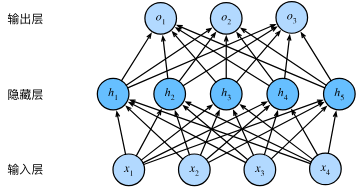
图4.1.1 一个单隐藏层的多层感知机，具有5个隐藏单元

这个多层感知机有4个输入，3个输出，其隐藏层包含5个隐藏单元。
输入层不涉及任何计算，因此使用此网络产生输出只需要实现隐藏层和输出层的计算。
因此，这个多层感知机中的层数为2。
注意，这两个层都是全连接的。
每个输入都会影响隐藏层中的每个神经元，
而隐藏层中的每个神经元又会影响输出层中的每个神经元。

然而，正如[3.4.3节](./03.linear-networks.ipynb#全连接层的参数开销)所说，
具有全连接层的多层感知机的参数开销可能会高得令人望而却步。
即使在不改变输入或输出大小的情况下，
可能在参数节约和模型有效性之间进行权衡([Zhang et al., 2021](#paper.zhang.2021))。
> - Zhang, A., Tay, Y., Zhang, S., Chan, A., Luu, A. T., Hui, S. C., & Fu, J. (2021). Beyond fully-connected layers with quaternions: parameterization of hypercomplex multiplications with 1/n parameters. International Conference on Learning Representations.

#### 从线性到非线性

同之前的章节一样，
我们通过矩阵$\mathbf{X} \in \mathbb{R}^{n \times d}$
来表示$n$个样本的小批量，
其中每个样本具有$d$个输入特征。
对于具有$h$个隐藏单元的单隐藏层多层感知机，
用$\mathbf{H} \in \mathbb{R}^{n \times h}$表示隐藏层的输出，
称为*隐藏表示*（hidden representations）。
在数学或代码中，$\mathbf{H}$也被称为*隐藏层变量*（hidden-layer variable）
或*隐藏变量*（hidden variable）。
因为隐藏层和输出层都是全连接的，
所以我们有隐藏层权重$\mathbf{W}^{(1)} \in \mathbb{R}^{d \times h}$
和隐藏层偏置$\mathbf{b}^{(1)} \in \mathbb{R}^{1 \times h}$
以及输出层权重$\mathbf{W}^{(2)} \in \mathbb{R}^{h \times q}$
和输出层偏置$\mathbf{b}^{(2)} \in \mathbb{R}^{1 \times q}$。
形式上，我们按如下方式计算单隐藏层多层感知机的输出
$\mathbf{O} \in \mathbb{R}^{n \times q}$：

<span id='eq.4.1.1'></span>
$$ \begin{align}
\mathbf{H} & = \mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}, \tag{4.1.1}\\
\mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.
\end{align} $$

注意在添加隐藏层之后，模型现在需要跟踪和更新额外的参数。
可我们能从中得到什么好处呢？在上面定义的模型里，我们没有好处！
原因很简单：上面的隐藏单元由输入的仿射函数给出，
而输出（softmax操作前）只是隐藏单元的仿射函数。
仿射函数的仿射函数本身就是仿射函数，
但是我们之前的线性模型已经能够表示任何仿射函数。

我们可以证明这一等价性，即对于任意权重值，
我们只需合并隐藏层，便可产生具有参数
$\mathbf{W} = \mathbf{W}^{(1)}\mathbf{W}^{(2)}$
和$\mathbf{b} = \mathbf{b}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)}$
的等价单层模型:

<span id='eq.4.1.2'></span>
$$ \mathbf{O} = (\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})\mathbf{W}^{(2)} + \mathbf{b}^{(2)} = \mathbf{X} \mathbf{W}^{(1)}\mathbf{W}^{(2)} + \mathbf{b}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)} = \mathbf{X} \mathbf{W} + \mathbf{b}. \tag{4.1.2}$$

为了发挥多层架构的潜力，
我们还需要一个额外的<font color="red">**关键要素**：
在仿射变换之后对每个隐藏单元应用非线性的*激活函数*（activation function）$\sigma$。
激活函数的输出（例如，$\sigma(\cdot)$）被称为*活性值*（activations）</font>。
一般来说，<font color="red">有了激活函数，就不可能再将我们的多层感知机退化成线性模型</font>：

<span id='eq.4.1.3'></span>
$$ \begin{align}
\mathbf{H} & = \sigma(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}), \tag{4.1.3}\\
\mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.\\
\end{align} $$

由于$\mathbf{X}$中的每一行对应于小批量中的一个样本，
出于记号习惯的考量，
我们定义非线性函数$\sigma$也以按行的方式作用于其输入，
即一次计算一个样本。
我们在[3.4.5节](./03.linear-networks.ipynb#小批量样本的矢量化)中
以相同的方式使用了softmax符号来表示按行操作。
但是<font color="red">本节应用于隐藏层的激活函数通常不仅按行操作，也按元素操作。
这意味着在计算每一层的线性部分之后，我们可以计算每个活性值，
而不需要查看其他隐藏单元所取的值</font>。对于大多数激活函数都是这样。

为了构建更通用的多层感知机，
我们可以继续堆叠这样的隐藏层，
例如$\mathbf{H}^{(1)} = \sigma_1(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})$和$\mathbf{H}^{(2)} = \sigma_2(\mathbf{H}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)})$，
一层叠一层，从而产生更有表达能力的模型。

#### 通用近似定理

多层感知机可以通过隐藏神经元，捕捉到输入之间复杂的相互作用，
这些神经元依赖于每个输入的值。
我们可以很容易地设计隐藏节点来执行任意计算。
例如，在一对输入上进行基本逻辑操作，多层感知机是通用近似器。
即使是网络只有一个隐藏层，给定足够的神经元和正确的权重，
我们可以对任意函数建模，尽管实际中学习该函数是很困难的。
神经网络有点像C语言。
C语言和任何其他现代编程语言一样，能够表达任何可计算的程序。
但实际上，想出一个符合规范的程序才是最困难的部分。

而且，虽然一个单隐层网络能学习任何函数，
但并不意味着我们应该尝试使用单隐藏层网络来解决所有问题。
事实上，通过使用更深（而不是更广）的网络，我们可以更容易地逼近许多函数。
我们将在后面的章节中进行更细致的讨论。

### 激活函数

<font color="red">*激活函数*（activation function）通过计算加权和并加上偏置来确定神经元是否应该被激活，
它们将输入信号转换为输出的可微运算</font>。
大多数激活函数都是非线性的。
由于激活函数是深度学习的基础，下面简要介绍一些常见的激活函数。

In [ ]:
import torch

#### ReLU函数

最受欢迎的激活函数是<font color="red">*修正线性单元*（Rectified linear unit，*ReLU*）</font>，
因为它实现简单，同时在各种预测任务中表现良好。
ReLU提供了一种非常简单的非线性变换。
给定元素$x$，ReLU函数被定义为该元素与$0$的最大值：

<span id='eq.4.1.4'></span>
$$\operatorname{ReLU}(x) = \max(x, 0). \tag{4.1.4}$$

通俗地说，ReLU函数通过将相应的活性值设为0，仅保留正元素并丢弃所有负元素。
为了直观感受一下，我们可以画出函数的曲线图。
正如从图中所看到，激活函数是分段线性的。

In [ ]:
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline

def set_figsize(figsize=(4, 3)):
    """Set the figure size for matplotlib."""
    backend_inline.set_matplotlib_formats('svg')
    """Set the figure size for matplotlib."""
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib.

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """Plot data points.

    Defined in :numref:`sec_calculus`"""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # Return True if `X` (tensor or list) has 1 axis
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

In [ ]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

当输入为负时，ReLU函数的导数为0，而当输入为正时，ReLU函数的导数为1。
注意，当输入值精确等于0时，ReLU函数不可导。
在此时，我们默认使用左侧的导数，即当输入为0时导数为0。
我们可以忽略这种情况，因为输入可能永远都不会是0。
这里引用一句古老的谚语，“如果微妙的边界条件很重要，我们很可能是在研究数学而非工程”，
这个观点正好适用于这里。
下面我们绘制ReLU函数的导数。

In [ ]:
y.backward(torch.ones_like(x), retain_graph=True)
plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5)) # todo: detach() is what

使用ReLU的原因是，它求导表现得特别好：要么让参数消失，要么让参数通过。
这使得优化表现得更好，并且ReLU减轻了困扰以往神经网络的梯度消失问题（稍后将详细介绍）。

注意，ReLU函数有许多变体，包括<font color="red">*参数化ReLU*（Parameterized ReLU，*pReLU*）函数([He et al., 2015](#paper.He.2015))。
该变体为ReLU添加了一个线性项，因此即使参数是负的，某些信息仍然可以通过</font>：

<span id='eq.4.1.5'></span>
$$\operatorname{pReLU}(x) = \max(0, x) + \alpha \min(0, x). \tag{4.1.5}$$

> - He, K., Zhang, X., Ren, S., & Sun, J. (2015). Delving deep into rectifiers: surpassing human-level performance on imagenet classification. Proceedings of the IEEE international conference on computer vision (pp. 1026–1034).

#### sigmoid函数

对于一个定义域在$\mathbb{R}$中的输入，
*sigmoid函数*将输入变换为区间(0, 1)上的输出。
因此，<font color="red">sigmoid通常称为*挤压函数*（squashing function）：
它将范围（-inf, inf）中的任意输入压缩到区间（0, 1）中的某个值</font>：

<span id='eq.4.1.6'></span>
$$\operatorname{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.\tag{4.1.6}$$

在最早的神经网络中，科学家们感兴趣的是对“激发”或“不激发”的生物神经元进行建模。
因此，这一领域的先驱可以一直追溯到人工神经元的发明者麦卡洛克和皮茨，他们专注于阈值单元。
阈值单元在其输入低于某个阈值时取值0，当输入超过阈值时取值1。

当人们逐渐关注到到基于梯度的学习时，
sigmoid函数是一个自然的选择，因为它是一个<font color="red">平滑的、可微的</font>阈值单元近似。
<font color="red">当我们想要将输出视作二元分类问题的概率时，
sigmoid仍然被广泛用作输出单元上的激活函数
（sigmoid可以视为softmax的特例）</font>。
然而，<font color="blue">sigmoid在隐藏层中已经较少使用，
它在大部分时候被更简单、更容易训练的ReLU所取代</font>。
在后面关于循环神经网络的章节中，我们将描述利用sigmoid单元来控制时序信息流的架构。

下面，我们绘制sigmoid函数。
注意，当输入接近0时，sigmoid函数接近线性变换。

In [ ]:
y = torch.sigmoid(x)
plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

sigmoid函数的导数为下面的公式：

<span id='eq.4.1.7'></span>
$$\frac{d}{dx} \operatorname{sigmoid}(x) = \frac{\exp(-x)}{(1 + \exp(-x))^2} = \operatorname{sigmoid}(x)\left(1-\operatorname{sigmoid}(x)\right).\tag{4.1.7}$$

sigmoid函数的导数图像如下所示。
注意，当输入为0时，sigmoid函数的导数达到最大值0.25；
而输入在任一方向上越远离0点时，导数越接近0。

In [ ]:
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

#### tanh函数

与sigmoid函数类似，
<font color="red">tanh(双曲正切)函数也能将其输入压缩转换到区间(-1, 1)上</font>。
tanh函数的公式如下：

<span id='eq.4.1.8'></span>
$$\operatorname{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}.\tag{4.1.8}$$

下面我们绘制tanh函数。
注意，当输入在0附近时，tanh函数接近线性变换。
函数的形状<font color="red">类似于sigmoid函数，
不同的是tanh函数关于坐标系原点中心对称</font>。

In [ ]:
y = torch.tanh(x)
plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

tanh函数的导数是：

$$\frac{d}{dx} \operatorname{tanh}(x) = 1 - \operatorname{tanh}^2(x).$$

tanh函数的导数图像如下所示。
当输入接近0时，tanh函数的导数接近最大值1。
与我们在sigmoid函数图像中看到的类似，
输入在任一方向上越远离0点，导数越接近0。

In [ ]:
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

总结一下，我们现在了解了如何结合非线性函数来构建具有更强表达能力的多层神经网络架构。
顺便说一句，这些知识已经让你掌握了一个类似于1990年左右深度学习从业者的工具。
在某些方面，你比在20世纪90年代工作的任何人都有优势，
因为你可以利用功能强大的开源深度学习框架，只需几行代码就可以快速构建模型，
而以前训练这些网络需要研究人员编写数千行的C或Fortran代码。

### 小结

* 多层感知机在输出层和输入层之间增加一个或多个全连接隐藏层，并通过激活函数转换隐藏层的输出。
* 常用的激活函数包括ReLU函数、sigmoid函数和tanh函数。

## 多层感知机的从零开始实现

我们已经在[4.1节](#)中描述了多层感知机（MLP），
现在让我们尝试自己实现一个多层感知机。
为了与之前softmax回归([3.6节](./03.linear-networks.ipynb#softmax回归的从零开始实现))
获得的结果进行比较，
我们将继续使用Fashion-MNIST图像分类数据集([3.5节](./03.linear-networks.ipynb#softmax图像分类数据集))。

In [ ]:
import torch
import torchvision
from torch import nn
from torch.utils import data
from torchvision import transforms

def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    num_workers = 0
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, 
                            shuffle=True,             # 随机打乱所有样本
                            num_workers=num_workers), # 使用 num_workers 个进程来读取数据
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=num_workers))

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

### 初始化模型参数

回想一下，Fashion-MNIST中的每个图像由
$28 \times 28 = 784$个灰度像素值组成。
所有图像共分为10个类别。
忽略像素之间的空间结构，
我们可以将每个图像视为具有784个输入特征
和10个类的简单分类数据集。
首先，我们将实现一个具有单隐藏层的多层感知机，
它包含256个隐藏单元。
注意，我们可以将这两个变量都视为超参数。
<font color="red">通常，我们选择2的若干次幂作为层的宽度。
因为内存在硬件中的分配和寻址方式，这么做往往可以在计算上更高效</font>。

我们用几个张量来表示我们的参数。
注意，对于每一层我们都要记录一个权重矩阵和一个偏置向量。
跟以前一样，我们要为损失关于这些参数的梯度分配内存。

In [ ]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(
    num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(
    num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

### 激活函数

为了确保我们对模型的细节了如指掌，
我们将实现ReLU激活函数，
而不是直接调用内置的`relu`函数。

In [ ]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

### 模型

因为我们忽略了空间结构，
所以我们使用`reshape`将每个二维图像转换为一个长度为`num_inputs`的向量。
只需几行代码就可以实现我们的模型。

In [ ]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)  # 这里“@”代表矩阵乘法
    return (H@W2 + b2)

### 损失函数

由于我们已经从零实现过softmax函数([3.6节](./03.linear-networks.ipynb#softmax回归的从零开始实现))，
因此在这里我们直接使用高级API中的内置函数来计算softmax和交叉熵损失。
回想一下我们之前在[3.7.2节](./03.linear-networks.ipynb#重新审视Softmax的实现)中
对这些复杂问题的讨论。
我们鼓励感兴趣的读者查看损失函数的源代码，以加深对实现细节的了解。

In [ ]:
loss = nn.CrossEntropyLoss(reduction='none')

### 训练

幸运的是，多层感知机的训练过程与softmax回归的训练过程完全相同。
可以直接调用`train_ch3`函数（参见[3.6节](./03.linear-networks.ipynb#softmax回归的从零开始实现)），
将迭代周期数设置为10，并将学习率设置为0.1.

In [ ]:
from IPython import display
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib.

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        backend_inline.set_matplotlib_formats('svg')
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [ ]:
class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def accuracy(y_hat, y): # 评估
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()                          # 将模型设置为评估模式
    metric = Accumulator(2)                 # 累加器: 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), # 当前分类正确次数
                       y.numel())           # 当前样本数量
    return metric[0] / metric[1]            # 返回测试集的分类准确率

def train_epoch_ch3(net, train_iter, loss, trainer):
    """训练模型一个迭代周期"""
    if isinstance(net, torch.nn.Module):
        net.train()                         # 将模型设置为训练模式
    metric = Accumulator(3)                 # 累加器: 训练损失总和、训练准确度总和、样本数
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)                  # 计算损失函数loss(前向传播)
        if isinstance(trainer, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            trainer.zero_grad()             # 梯度清零
            l.mean().backward()             # 反向传播计算梯度
            trainer.step()                  # 用优化器更新模型参数
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            trainer(X.shape[0])
        metric.add(float(l.sum()),          # 训练损失总和
                   accuracy(y_hat, y),      # 训练准确度总和
                   y.numel())               # 样本数
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2] # 返回训练集的平均损失和分类准确率

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [ ]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

为了对学习到的模型进行评估，我们将在一些测试数据上应用这个模型。

In [ ]:
def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

def predict_ch3(net, test_iter, n=6):
    """预测标签"""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n]) # show_images() 定义在"3.5.1 读取数据集"

In [ ]:
predict_ch3(net, test_iter)

### 小结

* 手动实现一个简单的多层感知机是很容易的。然而如果有大量的层，从零开始实现多层感知机会变得很麻烦（例如，要命名和记录模型的参数）。

## 多层感知机的简洁实现

本节将介绍通过高级API更简洁地实现多层感知机。

In [ ]:
import torch
from torch import nn

### 模型

与softmax回归的简洁实现([3.7节](./03.linear-networks.ipynb#softmax回归的简洁实现))相比，
唯一的区别是我们添加了2个全连接层（之前我们只添加了1个全连接层）。
第一层是隐藏层，它包含256个隐藏单元，并使用了ReLU激活函数。
第二层是输出层。

In [ ]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

训练过程的实现与我们实现softmax回归时完全相同，
这种模块化设计使我们能够将与模型架构有关的内容独立出来。

In [ ]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train_iter, test_iter = load_data_fashion_mnist(batch_size)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### 小结

* 我们可以使用高级API更简洁地实现多层感知机。
* 对于相同的分类问题，多层感知机的实现与softmax回归的实现相同，只是多层感知机的实现里增加了带有激活函数的隐藏层。

## 模型选择、欠拟合和过拟合

作为机器学习科学家，我们的目标是发现*模式*（pattern）。
但是，我们如何才能确定模型是真正发现了一种泛化的模式，
而不是简单地记住了数据呢？
例如，我们想要在患者的基因数据与痴呆状态之间寻找模式，
其中标签是从集合$\{\text{痴呆}, \text{轻度认知障碍}, \text{健康}\}$中提取的。
因为基因可以唯一确定每个个体（不考虑双胞胎），
所以在这个任务中是有可能记住整个数据集的。

我们不想让模型只会做这样的事情：“那是鲍勃！我记得他！他有痴呆症！”。
原因很简单：当我们将来部署该模型时，模型需要判断从未见过的患者。
只有当模型真正发现了一种泛化模式时，才会作出有效的预测。

更正式地说，我们的目标是发现某些模式，
这些模式捕捉到了我们训练集潜在总体的规律。
如果成功做到了这点，即使是对以前从未遇到过的个体，
模型也可以成功地评估风险。
<font color="red">如何发现可以泛化的模式是机器学习的根本问题</font>。

困难在于，当我们训练模型时，我们只能访问数据中的小部分样本。
最大的公开图像数据集包含大约一百万张图像。
而在大部分时候，我们只能从数千或数万个数据样本中学习。
在大型医院系统中，我们可能会访问数十万份医疗记录。
当我们使用有限的样本时，可能会遇到这样的问题：
当收集到更多的数据时，会发现之前找到的明显关系并不成立。

将模型在训练数据上拟合的比在潜在分布中更接近的现象称为*过拟合*（overfitting），
用于<font color="red">对抗过拟合的技术称为*正则化*（regularization）</font>。
在前面的章节中，有些读者可能在用Fashion-MNIST数据集做实验时已经观察到了这种过拟合现象。
在实验中调整模型架构或超参数时会发现：
如果有足够多的神经元、层数和训练迭代周期，
模型最终可以在训练集上达到完美的精度，此时测试集的准确性却下降了。

### 训练误差和泛化误差

为了进一步讨论这一现象，我们需要了解训练误差和泛化误差。
*训练误差*（training error）是指，
模型在训练数据集上计算得到的误差。
*泛化误差*（generalization error）是指，
模型应用在同样从原始样本的分布中抽取的无限多数据样本时，模型误差的期望。

问题是，我们永远不能准确地计算出泛化误差。
这是因为无限多的数据样本是一个虚构的对象。
在实际中，我们只能<font color="red">通过将模型应用于一个独立的测试集来估计泛化误差，
该测试集由随机选取的、未曾在训练集中出现的数据样本构成</font>。

下面的三个思维实验将有助于更好地说明这种情况。
假设一个大学生正在努力准备期末考试。
一个勤奋的学生会努力做好练习，并利用往年的考试题目来测试自己的能力。
尽管如此，在过去的考试题目上取得好成绩并不能保证他会在真正考试时发挥出色。
例如，学生可能试图通过死记硬背考题的答案来做准备。
他甚至可以完全记住过去考试的答案。
另一名学生可能会通过试图理解给出某些答案的原因来做准备。
在大多数情况下，后者会考得更好。

类似地，考虑一个简单地使用查表法来回答问题的模型。
如果允许的输入集合是离散的并且相当小，
那么也许在查看许多训练样本后，该方法将执行得很好。
但当这个模型面对从未见过的例子时，它表现的可能比随机猜测好不到哪去。
这是因为输入空间太大了，远远不可能记住每一个可能的输入所对应的答案。
例如，考虑$28\times28$的灰度图像。
如果每个像素可以取$256$个灰度值中的一个，
则有$256^{784}$个可能的图像。
这意味着指甲大小的低分辨率灰度图像的数量比宇宙中的原子要多得多。
即使我们可能遇到这样的数据，我们也不可能存储整个查找表。

最后，考虑对掷硬币的结果（类别0：正面，类别1：反面）进行分类的问题。
假设硬币是公平的，无论我们想出什么算法，泛化误差始终是$\frac{1}{2}$。
然而，对于大多数算法，我们应该期望训练误差会更低（取决于运气）。
考虑数据集{0，1，1，1，0，1}。
我们的算法不需要额外的特征，将倾向于总是预测*多数类*，
从我们有限的样本来看，它似乎是1占主流。
在这种情况下，总是预测类1的模型将产生$\frac{1}{3}$的误差，
这比我们的泛化误差要好得多。
当我们逐渐增加数据量，正面比例明显偏离$\frac{1}{2}$的可能性将会降低，
我们的训练误差将与泛化误差相匹配。

#### 统计学习理论

由于泛化是机器学习中的基本问题，
许多数学家和理论家毕生致力于研究描述这一现象的形式理论。
在[同名定理（eponymous theorem）](https://en.wikipedia.org/wiki/Glivenko%E2%80%93Cantelli_theorem)中，
格里文科和坎特利推导出了训练误差收敛到泛化误差的速率。
在一系列开创性的论文中，
[Vapnik和Chervonenkis](https://en.wikipedia.org/wiki/Vapnik%E2%80%93Chervonenkis_theory)
将这一理论扩展到更一般种类的函数。
这项工作为统计学习理论奠定了基础。

在我们目前已探讨、并将在之后继续探讨的监督学习情景中，
我们假设训练数据和测试数据都是从相同的分布中独立提取的。
这通常被称为*独立同分布假设*（i.i.d. assumption），
这意味着对数据进行采样的过程没有进行“记忆”。
换句话说，抽取的第2个样本和第3个样本的相关性，
并不比抽取的第2个样本和第200万个样本的相关性更强。

要成为一名优秀的机器学习科学家需要具备批判性思考能力。
假设是存在漏洞的，即很容易找出假设失效的情况。
如果我们根据从加州大学旧金山分校医学中心的患者数据训练死亡风险预测模型，
并将其应用于马萨诸塞州综合医院的患者数据，结果会怎么样？
这两个数据的分布可能不完全一样。
此外，抽样过程可能与时间有关。
比如当我们对微博的主题进行分类时，
新闻周期会使得正在讨论的话题产生时间依赖性，从而违反独立性假设。

有时候我们<font color="red">即使轻微违背独立同分布假设，模型仍将继续运行得非常好</font>。
比如，我们有许多有用的工具已经应用于现实，如人脸识别、语音识别和语言翻译。
毕竟，几乎所有现实的应用都至少涉及到一些违背独立同分布假设的情况。

有些违背独立同分布假设的行为肯定会带来麻烦。
比如，我们试图只用来自大学生的人脸数据来训练一个人脸识别系统，
然后想要用它来监测疗养院中的老人。
这不太可能有效，因为大学生看起来往往与老年人有很大的不同。

在接下来的章节中，我们将讨论因违背独立同分布假设而引起的问题。
目前，即使认为独立同分布假设是理所当然的，理解泛化性也是一个困难的问题。
此外，能够解释深层神经网络泛化性能的理论基础，
也仍在继续困扰着学习理论领域最伟大的学者们。

当我们训练模型时，我们试图找到一个能够尽可能拟合训练数据的函数。
但是如果它执行地“太好了”，而不能对看不见的数据做到很好泛化，就会导致过拟合。
这种情况正是我们想要避免或控制的。
深度学习中有许多启发式的技术旨在防止过拟合。

#### 模型复杂性

当我们有简单的模型和大量的数据时，我们期望泛化误差与训练误差相近。
当我们有更复杂的模型和更少的样本时，我们预计训练误差会下降，但泛化误差会增大。
模型复杂性由什么构成是一个复杂的问题。
一个模型是否能很好地泛化取决于很多因素。
例如，具有更多参数的模型可能被认为更复杂，
参数有更大取值范围的模型可能更为复杂。
通常对于神经网络，我们认为需要更多训练迭代的模型比较复杂，
而需要*早停*（early stopping）的模型（即较少训练迭代周期）就不那么复杂。

我们很难比较本质上不同大类的模型之间（例如，决策树与神经网络）的复杂性。
就目前而言，一条简单的经验法则相当有用：
统计学家认为，<font color="red">能够轻松解释任意事实的模型是复杂的，
而表达能力有限但仍能很好地解释数据的模型可能更有现实用途</font>。
在哲学上，这与波普尔的科学理论的可证伪性标准密切相关：
如果一个理论能拟合数据，且有具体的测试可以用来证明它是错误的，那么它就是好的。
这一点很重要，因为所有的统计估计都是*事后归纳*。
也就是说，我们在观察事实之后进行估计，因此容易受到相关谬误的影响。
目前，我们将把哲学放在一边，坚持更切实的问题。

本节为了给出一些直观的印象，我们将重点介绍几个倾向于<font color="red">影响模型泛化的因素</font>。

1. 可调整参数的数量。当可调整参数的数量（有时称为*自由度*）很大时，模型往往更容易过拟合。
1. 参数采用的值。当权重的取值范围较大时，模型可能更容易过拟合。
1. 训练样本的数量。即使模型很简单，也很容易过拟合只包含一两个样本的数据集。而过拟合一个有数百万个样本的数据集则需要一个极其灵活的模型。

### 模型选择

在机器学习中，我们通常在评估几个候选模型后选择最终的模型。
这个过程叫做*模型选择*。
有时，需要进行比较的模型在本质上是完全不同的（比如，决策树与线性模型）。
又有时，我们需要比较不同的超参数设置下的同一类模型。

例如，训练多层感知机模型时，我们可能希望比较具有
不同数量的隐藏层、不同数量的隐藏单元以及不同的激活函数组合的模型。
为了确定候选模型中的最佳模型，我们通常会使用验证集。

#### 验证集

原则上，<font color="red">在我们确定所有的超参数之前，我们不希望用到测试集</font>。
如果我们在模型选择过程中使用测试数据，可能会有过拟合测试数据的风险，那就麻烦大了。
如果我们过拟合了训练数据，还可以在测试数据上的评估来判断过拟合。
但是如果我们过拟合了测试数据，我们又该怎么知道呢？

因此，我们决不能依靠测试数据进行模型选择。
然而，我们也不能仅仅依靠训练数据来选择模型，因为我们无法估计训练数据的泛化误差。

在实际应用中，情况变得更加复杂。
虽然理想情况下我们只会使用测试数据一次，
以评估最好的模型或比较一些模型效果，但现实是测试数据很少在使用一次后被丢弃。
我们很少能有充足的数据来对每一轮实验采用全新测试集。

解决此问题的常见做法是将我们的数据分成三份，
除了训练和测试数据集之外，还增加一个*验证数据集*（validation dataset），
也叫*验证集*（validation set）。
但现实是验证数据和测试数据之间的边界模糊得令人担忧。
除非另有明确说明，否则在这本书的实验中，
<font color="red">我们实际上是在使用应该被正确地称为训练数据和验证数据的数据集，
并没有真正的测试数据集。
因此，书中每次实验报告的准确度都是验证集准确度，而不是测试集准确度</font>。

#### $K$折交叉验证

当训练数据稀缺时，我们甚至可能无法提供足够的数据来构成一个合适的验证集。
这个问题的一个流行的解决方案是采用$K$*折交叉验证*。
这里，原始训练数据被分成$K$个不重叠的子集。
然后<font color="red">执行$K$次模型训练和验证，每次在$K-1$个子集上进行训练，
并在剩余的一个子集（在该轮中没有用于训练的子集）上进行验证。
最后，通过对$K$次实验的结果取平均来估计训练和验证误差</font>。

### 欠拟合还是过拟合？

当我们比较训练和验证误差时，我们要注意两种常见的情况。
首先，我们要注意这样的情况：<font color="red">训练误差和验证误差都很严重，
但它们之间仅有一点差距。
如果模型不能降低训练误差，这可能意味着模型过于简单（即表达能力不足），
无法捕获试图学习的模式</font>。
此外，由于我们的<font color="red">训练和验证误差之间的*泛化误差*很小</font>，
我们有理由相信可以用一个更复杂的模型降低训练误差。
<font color="red">这种现象被称为*欠拟合*（underfitting）</font>。

另一方面，<font color="red">当我们的训练误差明显低于验证误差时要小心，
这表明严重的*过拟合*（overfitting）</font>。
注意，*过拟合*并不总是一件坏事。
特别是在深度学习领域，众所周知，
最好的预测模型在训练数据上的表现往往比在保留（验证）数据上好得多。
最终，我们<font color="red">通常更关心验证误差，而不是训练误差和验证误差之间的差距</font>。

是否过拟合或欠拟合可能取决于模型复杂性和可用训练数据集的大小，
这两个点将在下面进行讨论。

#### 模型复杂性

为了说明一些关于过拟合和模型复杂性的经典直觉，
我们给出一个多项式的例子。
给定由单个特征$x$和对应实数标签$y$组成的训练数据，
我们试图找到下面的$d$阶多项式来估计标签$y$。

<span id='eq.4.4.1'></span>
$$\hat{y}= \sum_{i=0}^d x^i w_i \tag{4.4.1}$$

这只是一个线性回归问题，我们的特征是$x$的幂给出的，
模型的权重是$w_i$给出的，偏置是$w_0$给出的
（因为对于所有的$x$都有$x^0 = 1$）。
由于这只是一个线性回归问题，我们可以使用平方误差作为我们的损失函数。

高阶多项式函数比低阶多项式函数复杂得多。
高阶多项式的参数较多，模型函数的选择范围较广。
因此在固定训练数据集的情况下，
高阶多项式函数相对于低阶多项式的训练误差应该始终更低（最坏也是相等）。
事实上，当数据样本包含了$x$的不同值时，
<font color="blue">函数阶数等于数据样本数量的多项式函数可以完美拟合训练集</font>。
在[图4.4.1](#fig.4.4.1)中，
我们直观地描述了多项式的阶数和欠拟合与过拟合之间的关系。

<span id='fig.4.4.1'></span>
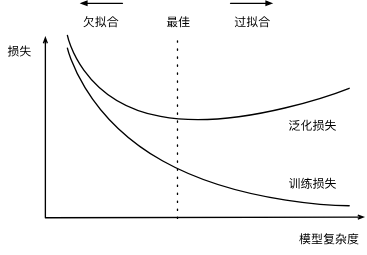
图4.4.1 模型复杂度对欠拟合和过拟合的影响

#### 数据集大小

另一个重要因素是数据集的大小。
训练数据集中的样本越少，我们就越有可能（且更严重地）过拟合。
随着训练数据量的增加，泛化误差通常会减小。
此外，一般来说，更多的数据不会有什么坏处。
对于固定的任务和数据分布，模型复杂性和数据集大小之间通常存在关系。
给出更多的数据，我们可能会尝试拟合一个更复杂的模型。
能够拟合更复杂的模型可能是有益的。
<font color="red">如果没有足够的数据，简单的模型可能更有用。
对于许多任务，深度学习只有在有数千个训练样本时才优于线性模型</font>。
从一定程度上来说，深度学习目前的生机要归功于
廉价存储、互联设备以及数字化经济带来的海量数据集。

### 多项式回归

我们现在可以通过多项式拟合来探索这些概念。

In [ ]:
import math
import numpy as np
import torch
from torch import nn

#### 生成数据集

给定$x$，我们将使用以下三阶多项式来生成训练和测试数据的标签：

<span id='eq.4.4.2'></span>
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).\tag{4.4.2}$$

噪声项$\epsilon$服从均值为0且标准差为0.1的正态分布。
在优化的过程中，我们通常希望避免非常大的梯度值或损失值。
这就是我们将特征从$x^i$调整为$\frac{x^i}{i!}$的原因，
这样可以避免很大的$i$带来的特别大的指数值。
我们将为训练集和测试集各生成100个样本。

In [ ]:
max_degree = 20               # 多项式的最大阶数
n_train, n_test = 100, 100    # 训练和测试数据集大小
true_w = np.zeros(max_degree) # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))                  # 200 * 1
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1)) # 200 * 20
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)                                   # (200 * 20) * (20 * 1) = (200 * 1)
labels += np.random.normal(scale=0.1, size=labels.shape)

同样，存储在`poly_features`中的单项式由gamma函数重新缩放，
其中$\Gamma(n)=(n-1)!$。
从生成的数据集中查看一下前2个样本，
第一个值是与偏置相对应的常量特征。

In [ ]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

#### 对模型进行训练和测试

首先让我们实现一个函数来评估模型在给定数据集上的损失。

In [ ]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = Accumulator(2)  # 损失的总和,样本数量. Accumulator() 定义于"4.2.5 训练"
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

现在定义训练函数。

In [ ]:
from torch.utils import data

def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [ ]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    # 1. 加载数据
    batch_size = min(10, train_labels.shape[0])
    train_iter = load_array((train_features, train_labels.reshape(-1,1)), batch_size)
    test_iter = load_array((test_features, test_labels.reshape(-1,1)), batch_size, is_train=False)
    
    # 2. 定义模型
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    
    # 3. 损失函数
    loss = nn.MSELoss(reduction='none')
    
    # 4. 优化算法
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    
    animator = Animator(xlabel='epoch', ylabel='loss', yscale='log', # Animator() 定义于"4.2.5 训练"
                        xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                        legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

#### 三阶多项式函数拟合(正常)

我们将首先使用三阶多项式函数，它与数据生成函数的阶数相同。
结果表明，该模型能有效降低训练损失和测试损失。
学习到的模型参数也接近真实值$w = [5, 1.2, -3.4, 5.6]$。

In [ ]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

#### 线性函数拟合(欠拟合)

让我们再看看线性函数拟合，减少该模型的训练损失相对困难。
在最后一个迭代周期完成后，训练损失仍然很高。
当用来拟合非线性模式（如这里的三阶多项式函数）时，线性模型容易欠拟合。

In [ ]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

#### 高阶多项式函数拟合(过拟合)

现在，让我们尝试使用一个阶数过高的多项式来训练模型。
在这种情况下，<font color="red">没有足够的数据用于学到高阶系数应该具有接近于零的值。
因此，这个过于复杂的模型会轻易受到训练数据中噪声的影响</font>。
虽然训练损失可以有效地降低，但测试损失仍然很高。
结果表明，复杂模型对数据造成了过拟合。

In [ ]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

在接下来的章节中，我们将继续讨论过拟合问题和处理这些问题的方法，例如权重衰减和dropout。

### 小结

* <font color="red">欠拟合是指模型无法继续减少训练误差。过拟合是指训练误差远小于验证误差</font>。
* 由于不能基于训练误差来估计泛化误差，因此简单地最小化训练误差并不一定意味着泛化误差的减小。机器学习模型需要注意防止过拟合，即防止泛化误差过大。
* 验证集可以用于模型选择，但不能过于随意地使用它。
* 我们应该选择一个复杂度适当的模型，避免使用数量不足的训练样本。

## 权重衰减

前一节我们描述了过拟合的问题，本节我们将介绍一些正则化模型的技术。
我们总是可以通过去收集更多的训练数据来缓解过拟合。
但这可能成本很高，耗时颇多，或者完全超出我们的控制，因而在短期内不可能做到。
假设我们已经拥有尽可能多的高质量数据，我们便可以将重点放在正则化技术上。

回想一下，在多项式回归的例子([4.4节](#模型选择、欠拟合和过拟合))中，
我们可以通过调整拟合多项式的阶数来限制模型的容量。
实际上，限制特征的数量是缓解过拟合的一种常用技术。
然而，简单地丢弃特征对这项工作来说可能过于生硬。
我们继续思考多项式回归的例子，考虑高维输入可能发生的情况。
多项式对多变量数据的自然扩展称为*单项式*（monomials），
也可以说是变量幂的乘积。
单项式的阶数是幂的和。
例如，$x_1^2 x_2$和$x_3 x_5^2$都是3次单项式。

注意，随着阶数$d$的增长，带有阶数$d$的项数迅速增加。 
给定$k$个变量，阶数为$d$的项的个数为
${k - 1 + d} \choose {k - 1}$，即$C^{k-1}_{k-1+d} = \frac{(k-1+d)!}{(d)!(k-1)!}$。
因此即使是阶数上的微小变化，比如从$2$到$3$，也会显著增加我们模型的复杂性。
仅仅通过简单的限制特征数量（在多项式回归中体现为限制阶数），可能仍然使模型在过简单和过复杂中徘徊，
我们需要一个更细粒度的工具来调整函数的复杂性，使其达到一个合适的平衡位置。

在[2.3.10节](./02.preliminaries.ipynb#范数)中，
我们已经描述了$L_2$范数和$L_1$范数，
它们是更为一般的$L_p$范数的特殊情况。

在训练参数化机器学习模型时，
*权重衰减*（weight decay）是最广泛使用的正则化的技术之一，
它通常也被称为$L_2$*正则化*。
这项技术通过函数与零的距离来衡量函数的复杂度，
因为在所有函数$f$中，函数$f = 0$（所有输入都得到值$0$）
在某种意义上是最简单的。
但是我们应该如何精确地测量一个函数和零之间的距离呢？
没有一个正确的答案。
事实上，函数分析和巴拿赫空间理论的研究，都在致力于回答这个问题。

一种简单的方法是通过线性函数
$f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x}$
中的权重向量的某个范数来度量其复杂性，
例如$\| \mathbf{w} \|^2$。
要保证权重向量比较小，
最常用方法是将其范数作为惩罚项加到最小化损失的问题中。
将原来的训练目标*最小化训练标签上的预测损失*，
调整为*最小化预测损失和惩罚项之和*。
现在，如果我们的权重向量增长的太大，
我们的学习算法可能会更集中于最小化权重范数$\| \mathbf{w} \|^2$。
这正是我们想要的。
让我们回顾一下[3.1节](./03.linear-networks.ipynb#线性回归)中的线性回归例子。
我们的损失由下式给出：

<span id='eq.4.5.1'></span>
$$L(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2. \tag{4.5.1}$$

回想一下，$\mathbf{x}^{(i)}$是样本$i$的特征，
$y^{(i)}$是样本$i$的标签，
$(\mathbf{w}, b)$是权重和偏置参数。
为了惩罚权重向量的大小，
我们必须以某种方式在损失函数中添加$\| \mathbf{w} \|^2$，
但是模型应该如何平衡这个新的额外惩罚的损失？
实际上，我们通过*正则化常数*$\lambda$来描述这种权衡，
这是一个非负超参数，我们使用验证数据拟合：

<span id='eq.4.5.2'></span>
$$L(\mathbf{w}, b) + \frac{\lambda}{2} \|\mathbf{w}\|^2, \tag{4.5.2}$$

对于$\lambda = 0$，我们恢复了原来的损失函数。
对于$\lambda > 0$，我们限制$\| \mathbf{w} \|$的大小。
这里我们仍然除以$2$：当我们取一个二次函数的导数时，
$2$和$1/2$会抵消，以确保更新表达式看起来既漂亮又简单。
为什么在这里我们使用平方范数而不是标准范数（即欧几里得距离）？
我们这样做是为了便于计算。
通过平方$L_2$范数，我们去掉平方根，留下权重向量每个分量的平方和。
这使得惩罚的导数很容易计算：导数的和等于和的导数。

此外，为什么我们首先使用$L_2$范数，而不是$L_1$范数。
事实上，这个选择在整个统计领域中都是有效的和受欢迎的。
$L_2$正则化线性模型构成经典的*岭回归*（ridge regression）算法，
$L_1$正则化线性回归是统计学中类似的基本模型，
通常被称为*套索回归*（lasso regression）。
使用$L_2$范数的一个原因是它对权重向量的大分量施加了巨大的惩罚。
这使得我们的学习算法偏向于在大量特征上均匀分布权重的模型。
在实践中，这可能使它们对单个变量中的观测误差更为稳定。
相比之下，$L_1$惩罚会导致模型将权重集中在一小部分特征上，
而将其他权重清除为零。
这称为*特征选择*（feature selection），这可能是其他场景下需要的。

使用与([3.1.10](./03.linear-networks.ipynb#eq.3.1.10))中的相同符号，
$L_2$正则化回归的小批量随机梯度下降更新如下式：

<span id='eq.4.5.3'></span>
$$ \begin{align}
\mathbf{w} & \leftarrow \left(1- \eta\lambda \right) \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right). \tag{4.5.3}
\end{align} $$

根据之前章节所讲的，我们根据估计值与观测值之间的差异来更新$\mathbf{w}$。
然而，我们同时也在试图将$\mathbf{w}$的大小缩小到零。
这就是为什么这种方法有时被称为*权重衰减*。
我们仅考虑惩罚项，优化算法在训练的每一步*衰减*权重。
与特征选择相比，权重衰减为我们提供了一种连续的机制来调整函数的复杂度。
较小的$\lambda$值对应较少约束的$\mathbf{w}$，
而较大的$\lambda$值对$\mathbf{w}$的约束更大。

是否对相应的偏置$b^2$进行惩罚在不同的实践中会有所不同，
在神经网络的不同层中也会有所不同。
通常，网络输出层的偏置项不会被正则化。

### 高维线性回归

我们通过一个简单的例子来演示权重衰减。

In [ ]:
import torch
from torch import nn

首先，我们像以前一样生成一些数据，生成公式如下：

<span id='eq.4.5.4'></span>
$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2). \tag{4.5.4}$$

我们选择标签是关于输入的线性函数。
标签同时被均值为0，标准差为0.01高斯噪声破坏。
为了使过拟合的效果更加明显，我们可以将问题的维数增加到$d = 200$，
并使用一个只包含20个样本的小训练集。

In [ ]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

### 从零开始实现

下面我们将从头开始实现权重衰减，只需将$L_2$的平方惩罚添加到原始目标函数中。

#### 初始化模型参数

首先，我们将定义一个函数来随机初始化模型参数。

In [ ]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

#### 定义$L_2$范数惩罚

实现这一惩罚最方便的方法是对所有项求平方后并将它们求和。

In [ ]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

#### 定义训练代码实现

下面的代码将模型拟合训练数据集，并在测试数据集上进行评估。
从[3节](./03.linear-networks.ipynb)以来，线性网络和平方损失没有变化，
所以我们通过`linreg`和`squared_loss`导入它们。
唯一的变化是损失现在包括了惩罚项。

In [ ]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

#### 忽略正则化直接训练

我们现在用`lambd = 0`禁用权重衰减后运行这个代码。
注意，这里训练误差有了减少，但测试误差没有减少，
这意味着出现了严重的过拟合。

In [ ]:
train(lambd=0)

#### 使用权重衰减

下面，我们使用权重衰减来运行代码。
注意，在这里训练误差增大，但测试误差减小。
这正是我们期望从正则化中得到的效果。

In [ ]:
train(lambd=3)

### 简洁实现

由于权重衰减在神经网络优化中很常用，
深度学习框架为了便于我们使用权重衰减，
将权重衰减集成到优化算法中，以便与任何损失函数结合使用。
此外，这种集成还有计算上的好处，
允许在不增加任何额外的计算开销的情况下向算法中添加权重衰减。
由于更新的权重衰减部分仅依赖于每个参数的当前值，
因此优化器必须至少接触每个参数一次。

在下面的代码中，我们在实例化优化器时直接通过`weight_decay`指定weight decay超参数。
默认情况下，PyTorch同时衰减权重和偏移。
这里我们只为权重设置了`weight_decay`，所以偏置参数$b$不会衰减。

In [ ]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

这些图看起来和我们从零开始实现权重衰减时的图相同。
然而，它们运行得更快，更容易实现。
对于更复杂的问题，这一好处将变得更加明显。

In [ ]:
train_concise(0)

In [ ]:
train_concise(3)

到目前为止，我们只接触到一个简单线性函数的概念。
此外，由什么构成一个简单的非线性函数可能是一个更复杂的问题。
例如，[再生核希尔伯特空间（RKHS）](https://en.wikipedia.org/wiki/Reproducing_kernel_Hilbert_space)
允许在非线性环境中应用为线性函数引入的工具。
不幸的是，基于RKHS的算法往往难以应用到大型、高维的数据。
在这本书中，我们将默认使用简单的启发式方法，即在深层网络的所有层上应用权重衰减。

### 小结

* 正则化是处理过拟合的常用方法：在训练集的损失函数中加入惩罚项，以降低学习到的模型的复杂度。
* 保持模型简单的一个特别的选择是使用$L_2$惩罚的权重衰减。这会导致学习算法更新步骤中的权重衰减。
* 权重衰减功能在深度学习框架的优化器中提供。
* 在同一训练代码实现中，不同的参数集可以有不同的更新行为。

## 暂退法（Dropout）

在[4.5节](#权重衰减)中，
我们介绍了通过惩罚权重的$L_2$范数来正则化统计模型的经典方法。
在概率角度看，我们可以通过以下论证来证明这一技术的合理性：
我们已经假设了一个先验，即权重的值取自均值为0的高斯分布。
更直观的是，我们希望模型深度挖掘特征，即将其权重分散到许多特征中，
而不是过于依赖少数潜在的虚假关联。

### 重新审视过拟合

当面对更多的特征而样本不足时，线性模型往往会过拟合。
相反，当给出更多样本而不是特征，通常线性模型不会过拟合。
不幸的是，线性模型泛化的可靠性是有代价的。
简单地说，线性模型没有考虑到特征之间的交互作用。
对于每个特征，线性模型必须指定正的或负的权重，而忽略其他特征。

泛化性和灵活性之间的这种基本权衡被描述为*偏差-方差权衡*（bias-variance tradeoff）。
线性模型有很高的偏差：它们只能表示一小类函数。
然而，这些模型的方差很低：它们在不同的随机数据样本上可以得出相似的结果。

深度神经网络位于偏差-方差谱的另一端。
与线性模型不同，神经网络并不局限于单独查看每个特征，而是学习特征之间的交互。
例如，神经网络可能推断“尼日利亚”和“西联汇款”一起出现在电子邮件中表示垃圾邮件，
但单独出现则不表示垃圾邮件。

即使我们有比特征多得多的样本，深度神经网络也有可能过拟合。
2017年，一组研究人员通过在随机标记的图像上训练深度网络。
这展示了神经网络的极大灵活性，因为人类很难将输入和随机标记的输出联系起来，
但通过随机梯度下降优化的神经网络可以完美地标记训练集中的每一幅图像。
想一想这意味着什么？
假设标签是随机均匀分配的，并且有10个类别，那么分类器在测试数据上很难取得高于10%的精度，
那么这里的泛化差距就高达90%，如此严重的过拟合。

深度网络的泛化性质令人费解，而这种泛化性质的数学基础仍然是悬而未决的研究问题。
我们鼓励喜好研究理论的读者更深入地研究这个主题。
本节，我们将着重对实际工具的探究，这些工具倾向于改进深层网络的泛化性。

### 扰动的稳健性

在探究泛化性之前，我们先来定义一下什么是一个“好”的预测模型？
我们期待“好”的预测模型能在未知的数据上有很好的表现：
经典泛化理论认为，为了缩小训练和测试性能之间的差距，应该以简单的模型为目标。
简单性以较小维度的形式展现，
我们在[4.4节](#模型选择、欠拟合和过拟合)讨论线性模型的单项式函数时探讨了这一点。
此外，正如我们在[4.5节](#权重衰减)中讨论权重衰减（$L_2$正则化）时看到的那样，
参数的范数也代表了一种有用的简单性度量。

简单性的另一个角度是平滑性，即函数不应该对其输入的微小变化敏感。
例如，当我们对图像进行分类时，我们预计向像素添加一些随机噪声应该是基本无影响的。
1995年，克里斯托弗·毕晓普证明了
具有输入噪声的训练等价于Tikhonov正则化([Bishop, 1995](#paper.Bishop.1995))。
这项工作用数学证实了“要求函数光滑”和“要求函数对输入的随机噪声具有适应性”之间的联系。

然后在2014年，斯里瓦斯塔瓦等人([Srivastava et al., 2014](#paper.Srivastava.2014))就如何将毕晓普的想法应用于网络的内部层提出了一个想法：
在训练过程中，他们建议在计算后续层之前向网络的每一层注入噪声。
因为当训练一个有多层的深层网络时，注入噪声只会在输入-输出映射上增强平滑性。

> - <span id='paper.Bishop.1995'></span> Bishop, C. M. (1995). Training with noise is equivalent to tikhonov regularization. Neural computation, 7(1), 108–116.
> - <span id='paper.Srivastava.2014'></span> Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: a simple way to prevent neural networks from overfitting. The Journal of Machine Learning Research, 15(1), 1929–1958.

这个想法被称为*暂退法*（dropout）。
暂退法在前向传播过程中，计算每一内部层的同时注入噪声，这已经成为训练神经网络的常用技术。
这种方法之所以被称为*暂退法*，因为我们从表面上看是在训练过程中丢弃（drop out）一些神经元。
在整个训练过程的每一次迭代中，标准暂退法包括在计算下一层之前将当前层中的一些节点置零。

需要说明的是，暂退法的原始论文提到了一个关于有性繁殖的类比：
神经网络过拟合与每一层都依赖于前一层激活值相关，称这种情况为“共适应性”。
作者认为，暂退法会破坏共适应性，就像有性生殖会破坏共适应的基因一样。

那么关键的挑战就是如何注入这种噪声。
一种想法是以一种*无偏向*（unbiased）的方式注入噪声。
这样在固定住其他层时，每一层的期望值等于没有噪音时的值。

在毕晓普的工作中，他将高斯噪声添加到线性模型的输入中。
在每次训练迭代中，他将从均值为零的分布$\epsilon \sim \mathcal{N}(0,\sigma^2)$
采样噪声添加到输入$\mathbf{x}$，
从而产生扰动点$\mathbf{x}' = \mathbf{x} + \epsilon$，
预期是$E[\mathbf{x}'] = \mathbf{x}$。

在标准暂退法正则化中，通过按保留（未丢弃）的节点的分数进行规范化来消除每一层的偏差。
换言之，每个中间活性值$h$以*暂退概率*$p$由随机变量$h'$替换，如下所示：

$$ \begin{align}
h' =
\begin{cases}
    0 & \text{ 概率为 } p \\
    \frac{h}{1-p} & \text{ 其他情况}
\end{cases}
\end{align} $$

根据此模型的设计，其期望值保持不变，即$E[h'] = h$。

### 实践中的暂退法

回想一下[图4.1.1](#fig.4.1.1)中带有1个隐藏层和5个隐藏单元的多层感知机。
当我们将暂退法应用到隐藏层，以$p$的概率将隐藏单元置为零时，
结果可以看作一个只包含原始神经元子集的网络。
比如在[图4.6.1](#fig.4.6.1)中，删除了$h_2$和$h_5$，
因此输出的计算不再依赖于$h_2$或$h_5$，并且它们各自的梯度在执行反向传播时也会消失。
这样，输出层的计算不能过度依赖于$h_1, \ldots, h_5$的任何一个元素。

<span id='fig.4.6.1'></span>
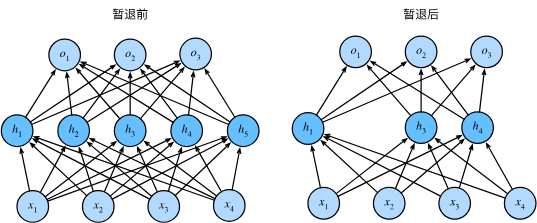
图4.6.1 dropout前后的多层感知机

通常，我们在测试时不用暂退法。
给定一个训练好的模型和一个新的样本，我们不会丢弃任何节点，因此不需要标准化。
然而也有一些例外：一些研究人员在测试时使用暂退法，
用于估计神经网络预测的“不确定性”：
如果通过许多不同的暂退法遮盖后得到的预测结果都是一致的，那么我们可以说网络发挥更稳定。

### 从零开始实现

要实现单层的暂退法函数，
我们从均匀分布$U[0, 1]$中抽取样本，样本数与这层神经网络的维度一致。
然后我们保留那些对应样本大于$p$的节点，把剩下的丢弃。

在下面的代码中，我们实现 `dropout_layer` 函数，
该函数以`dropout`的概率丢弃张量输入`X`中的元素，
如上所述重新缩放剩余部分：将剩余部分除以`1.0-dropout`。

In [ ]:
import torch
from torch import nn

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

我们可以通过下面几个例子来测试`dropout_layer`函数。
我们将输入`X`通过暂退法操作，暂退概率分别为0、0.5和1。

In [ ]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

#### 定义模型参数

同样，我们使用[3.5节](./03.linear-networks.ipynb#图像分类数据集)中引入的Fashion-MNIST数据集。
我们定义具有两个隐藏层的多层感知机，每个隐藏层包含256个单元。

In [ ]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

#### 定义模型

我们可以将暂退法应用于每个隐藏层的输出（在激活函数之后），
并且可以为每一层分别设置暂退概率：
常见的技巧是在靠近输入层的地方设置较低的暂退概率。
下面的模型将第一个和第二个隐藏层的暂退概率分别设置为0.2和0.5，
并且暂退法只在训练期间有效。

In [ ]:
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out


net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

#### 训练和测试

这类似于前面描述的多层感知机训练和测试。

In [ ]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### 简洁实现

对于深度学习框架的高级API，我们只需在每个全连接层之后添加一个`Dropout`层，
将暂退概率作为唯一的参数传递给它的构造函数。
在训练时，`Dropout`层将根据指定的暂退概率随机丢弃上一层的输出（相当于下一层的输入）。
在测试时，`Dropout`层仅传递数据。

In [ ]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

接下来，我们对模型进行训练和测试。

In [ ]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### 小结

* 暂退法在前向传播过程中，计算每一内部层的同时丢弃一些神经元。
* 暂退法可以避免过拟合，它通常与控制权重向量的维数和大小结合使用的。
* 暂退法将活性值$h$替换为具有期望值$h$的随机变量。
* 暂退法仅在训练期间使用。

# 前向传播、反向传播和计算图
:label:`sec_backprop`

我们已经学习了如何用小批量随机梯度下降训练模型。
然而当实现该算法时，我们只考虑了通过*前向传播*（forward propagation）所涉及的计算。
在计算梯度时，我们只调用了深度学习框架提供的反向传播函数，而不知其所以然。

梯度的自动计算（自动微分）大大简化了深度学习算法的实现。
在自动微分之前，即使是对复杂模型的微小调整也需要手工重新计算复杂的导数，
学术论文也不得不分配大量页面来推导更新规则。
本节将通过一些基本的数学和计算图，
深入探讨*反向传播*的细节。
首先，我们将重点放在带权重衰减（$L_2$正则化）的单隐藏层多层感知机上。

## 前向传播

*前向传播*（forward propagation或forward pass）
指的是：按顺序（从输入层到输出层）计算和存储神经网络中每层的结果。

我们将一步步研究单隐藏层神经网络的机制，
为了简单起见，我们假设输入样本是 $\mathbf{x}\in \mathbb{R}^d$，
并且我们的隐藏层不包括偏置项。
这里的中间变量是：

$$\mathbf{z}= \mathbf{W}^{(1)} \mathbf{x},$$

其中$\mathbf{W}^{(1)} \in \mathbb{R}^{h \times d}$
是隐藏层的权重参数。
将中间变量$\mathbf{z}\in \mathbb{R}^h$通过激活函数$\phi$后，
我们得到长度为$h$的隐藏激活向量：

$$\mathbf{h}= \phi (\mathbf{z}).$$

隐藏变量$\mathbf{h}$也是一个中间变量。
假设输出层的参数只有权重$\mathbf{W}^{(2)} \in \mathbb{R}^{q \times h}$，
我们可以得到输出层变量，它是一个长度为$q$的向量：

$$\mathbf{o}= \mathbf{W}^{(2)} \mathbf{h}.$$

假设损失函数为$l$，样本标签为$y$，我们可以计算单个数据样本的损失项，

$$L = l(\mathbf{o}, y).$$

根据$L_2$正则化的定义，给定超参数$\lambda$，正则化项为

$$s = \frac{\lambda}{2} \left(\|\mathbf{W}^{(1)}\|_F^2 + \|\mathbf{W}^{(2)}\|_F^2\right),$$
:eqlabel:`eq_forward-s`

其中矩阵的Frobenius范数是将矩阵展平为向量后应用的$L_2$范数。
最后，模型在给定数据样本上的正则化损失为：

$$J = L + s.$$

在下面的讨论中，我们将$J$称为*目标函数*（objective function）。

## 前向传播计算图

绘制*计算图*有助于我们可视化计算中操作符和变量的依赖关系。
 :numref:`fig_forward` 是与上述简单网络相对应的计算图，
 其中正方形表示变量，圆圈表示操作符。
 左下角表示输入，右上角表示输出。
 注意显示数据流的箭头方向主要是向右和向上的。

![前向传播的计算图](../img/forward.svg)
:label:`fig_forward`

## 反向传播

*反向传播*（backward propagation或backpropagation）指的是计算神经网络参数梯度的方法。
简言之，该方法根据微积分中的*链式规则*，按相反的顺序从输出层到输入层遍历网络。
该算法存储了计算某些参数梯度时所需的任何中间变量（偏导数）。
假设我们有函数$\mathsf{Y}=f(\mathsf{X})$和$\mathsf{Z}=g(\mathsf{Y})$，
其中输入和输出$\mathsf{X}, \mathsf{Y}, \mathsf{Z}$是任意形状的张量。
利用链式法则，我们可以计算$\mathsf{Z}$关于$\mathsf{X}$的导数

$$\frac{\partial \mathsf{Z}}{\partial \mathsf{X}} = \text{prod}\left(\frac{\partial \mathsf{Z}}{\partial \mathsf{Y}}, \frac{\partial \mathsf{Y}}{\partial \mathsf{X}}\right).$$

在这里，我们使用$\text{prod}$运算符在执行必要的操作（如换位和交换输入位置）后将其参数相乘。
对于向量，这很简单，它只是矩阵-矩阵乘法。
对于高维张量，我们使用适当的对应项。
运算符$\text{prod}$指代了所有的这些符号。

回想一下，在计算图 :numref:`fig_forward`中的单隐藏层简单网络的参数是
$\mathbf{W}^{(1)}$和$\mathbf{W}^{(2)}$。
反向传播的目的是计算梯度$\partial J/\partial \mathbf{W}^{(1)}$和
$\partial J/\partial \mathbf{W}^{(2)}$。
为此，我们应用链式法则，依次计算每个中间变量和参数的梯度。
计算的顺序与前向传播中执行的顺序相反，因为我们需要从计算图的结果开始，并朝着参数的方向努力。第一步是计算目标函数$J=L+s$相对于损失项$L$和正则项$s$的梯度。

$$\frac{\partial J}{\partial L} = 1 \; \text{and} \; \frac{\partial J}{\partial s} = 1.$$

接下来，我们根据链式法则计算目标函数关于输出层变量$\mathbf{o}$的梯度：

$$
\frac{\partial J}{\partial \mathbf{o}}
= \text{prod}\left(\frac{\partial J}{\partial L}, \frac{\partial L}{\partial \mathbf{o}}\right)
= \frac{\partial L}{\partial \mathbf{o}}
\in \mathbb{R}^q.
$$

接下来，我们计算正则化项相对于两个参数的梯度：

$$\frac{\partial s}{\partial \mathbf{W}^{(1)}} = \lambda \mathbf{W}^{(1)}
\; \text{and} \;
\frac{\partial s}{\partial \mathbf{W}^{(2)}} = \lambda \mathbf{W}^{(2)}.$$

现在我们可以计算最接近输出层的模型参数的梯度
$\partial J/\partial \mathbf{W}^{(2)} \in \mathbb{R}^{q \times h}$。
使用链式法则得出：

$$\frac{\partial J}{\partial \mathbf{W}^{(2)}}= \text{prod}\left(\frac{\partial J}{\partial \mathbf{o}}, \frac{\partial \mathbf{o}}{\partial \mathbf{W}^{(2)}}\right) + \text{prod}\left(\frac{\partial J}{\partial s}, \frac{\partial s}{\partial \mathbf{W}^{(2)}}\right)= \frac{\partial J}{\partial \mathbf{o}} \mathbf{h}^\top + \lambda \mathbf{W}^{(2)}.$$
:eqlabel:`eq_backprop-J-h`

为了获得关于$\mathbf{W}^{(1)}$的梯度，我们需要继续沿着输出层到隐藏层反向传播。
关于隐藏层输出的梯度$\partial J/\partial \mathbf{h} \in \mathbb{R}^h$由下式给出：

$$
\frac{\partial J}{\partial \mathbf{h}}
= \text{prod}\left(\frac{\partial J}{\partial \mathbf{o}}, \frac{\partial \mathbf{o}}{\partial \mathbf{h}}\right)
= {\mathbf{W}^{(2)}}^\top \frac{\partial J}{\partial \mathbf{o}}.
$$

由于激活函数$\phi$是按元素计算的，
计算中间变量$\mathbf{z}$的梯度$\partial J/\partial \mathbf{z} \in \mathbb{R}^h$
需要使用按元素乘法运算符，我们用$\odot$表示：

$$
\frac{\partial J}{\partial \mathbf{z}}
= \text{prod}\left(\frac{\partial J}{\partial \mathbf{h}}, \frac{\partial \mathbf{h}}{\partial \mathbf{z}}\right)
= \frac{\partial J}{\partial \mathbf{h}} \odot \phi'\left(\mathbf{z}\right).
$$

最后，我们可以得到最接近输入层的模型参数的梯度
$\partial J/\partial \mathbf{W}^{(1)} \in \mathbb{R}^{h \times d}$。
根据链式法则，我们得到：

$$
\frac{\partial J}{\partial \mathbf{W}^{(1)}}
= \text{prod}\left(\frac{\partial J}{\partial \mathbf{z}}, \frac{\partial \mathbf{z}}{\partial \mathbf{W}^{(1)}}\right) + \text{prod}\left(\frac{\partial J}{\partial s}, \frac{\partial s}{\partial \mathbf{W}^{(1)}}\right)
= \frac{\partial J}{\partial \mathbf{z}} \mathbf{x}^\top + \lambda \mathbf{W}^{(1)}.
$$

## 训练神经网络

在训练神经网络时，前向传播和反向传播相互依赖。
对于前向传播，我们沿着依赖的方向遍历计算图并计算其路径上的所有变量。
然后将这些用于反向传播，其中计算顺序与计算图的相反。

以上述简单网络为例：一方面，在前向传播期间计算正则项
 :eqref:`eq_forward-s`取决于模型参数$\mathbf{W}^{(1)}$和
$\mathbf{W}^{(2)}$的当前值。
它们是由优化算法根据最近迭代的反向传播给出的。
另一方面，反向传播期间参数 :eqref:`eq_backprop-J-h`的梯度计算，
取决于由前向传播给出的隐藏变量$\mathbf{h}$的当前值。

因此，在训练神经网络时，在初始化模型参数后，
我们交替使用前向传播和反向传播，利用反向传播给出的梯度来更新模型参数。
注意，反向传播重复利用前向传播中存储的中间值，以避免重复计算。
带来的影响之一是我们需要保留中间值，直到反向传播完成。
这也是训练比单纯的预测需要更多的内存（显存）的原因之一。
此外，这些中间值的大小与网络层的数量和批量的大小大致成正比。
因此，使用更大的批量来训练更深层次的网络更容易导致*内存不足*（out of memory）错误。

## 小结

* 前向传播在神经网络定义的计算图中按顺序计算和存储中间变量，它的顺序是从输入层到输出层。
* 反向传播按相反的顺序（从输出层到输入层）计算和存储神经网络的中间变量和参数的梯度。
* 在训练深度学习模型时，前向传播和反向传播是相互依赖的。
* 训练比预测需要更多的内存。

## 练习

1. 假设一些标量函数$\mathbf{X}$的输入$\mathbf{X}$是$n \times m$矩阵。$f$相对于$\mathbf{X}$的梯度维数是多少？
1. 向本节中描述的模型的隐藏层添加偏置项（不需要在正则化项中包含偏置项）。
    1. 画出相应的计算图。
    1. 推导正向和反向传播方程。
1. 计算本节所描述的模型，用于训练和预测的内存占用。
1. 假设想计算二阶导数。计算图发生了什么？预计计算需要多长时间？
1. 假设计算图对当前拥有的GPU来说太大了。
    1. 请试着把它划分到多个GPU上。
    1. 与小批量训练相比，有哪些优点和缺点？

[Discussions](https://discuss.d2l.ai/t/5769)

# 数值稳定性和模型初始化
:label:`sec_numerical_stability`

到目前为止，我们实现的每个模型都是根据某个预先指定的分布来初始化模型的参数。
有人会认为初始化方案是理所当然的，忽略了如何做出这些选择的细节。甚至有人可能会觉得，初始化方案的选择并不是特别重要。
相反，初始化方案的选择在神经网络学习中起着举足轻重的作用，
它对保持数值稳定性至关重要。
此外，这些初始化方案的选择可以与非线性激活函数的选择有趣的结合在一起。
我们选择哪个函数以及如何初始化参数可以决定优化算法收敛的速度有多快。
糟糕选择可能会导致我们在训练时遇到梯度爆炸或梯度消失。
本节将更详细地探讨这些主题，并讨论一些有用的启发式方法。
这些启发式方法在整个深度学习生涯中都很有用。

## 梯度消失和梯度爆炸

考虑一个具有$L$层、输入$\mathbf{x}$和输出$\mathbf{o}$的深层网络。
每一层$l$由变换$f_l$定义，
该变换的参数为权重$\mathbf{W}^{(l)}$，
其隐藏变量是$\mathbf{h}^{(l)}$（令 $\mathbf{h}^{(0)} = \mathbf{x}$）。
我们的网络可以表示为：

$$\mathbf{h}^{(l)} = f_l (\mathbf{h}^{(l-1)}) \text{ 因此 } \mathbf{o} = f_L \circ \ldots \circ f_1(\mathbf{x}).$$

如果所有隐藏变量和输入都是向量，
我们可以将$\mathbf{o}$关于任何一组参数$\mathbf{W}^{(l)}$的梯度写为下式：

$$\partial_{\mathbf{W}^{(l)}} \mathbf{o} = \underbrace{\partial_{\mathbf{h}^{(L-1)}} \mathbf{h}^{(L)}}_{ \mathbf{M}^{(L)} \stackrel{\mathrm{def}}{=}} \cdot \ldots \cdot \underbrace{\partial_{\mathbf{h}^{(l)}} \mathbf{h}^{(l+1)}}_{ \mathbf{M}^{(l+1)} \stackrel{\mathrm{def}}{=}} \underbrace{\partial_{\mathbf{W}^{(l)}} \mathbf{h}^{(l)}}_{ \mathbf{v}^{(l)} \stackrel{\mathrm{def}}{=}}.$$

换言之，该梯度是$L-l$个矩阵
$\mathbf{M}^{(L)} \cdot \ldots \cdot \mathbf{M}^{(l+1)}$
与梯度向量 $\mathbf{v}^{(l)}$的乘积。
因此，我们容易受到数值下溢问题的影响.
当将太多的概率乘在一起时，这些问题经常会出现。
在处理概率时，一个常见的技巧是切换到对数空间，
即将数值表示的压力从尾数转移到指数。
不幸的是，上面的问题更为严重：
最初，矩阵 $\mathbf{M}^{(l)}$ 可能具有各种各样的特征值。
他们可能很小，也可能很大；
他们的乘积可能非常大，也可能非常小。

不稳定梯度带来的风险不止在于数值表示；
不稳定梯度也威胁到我们优化算法的稳定性。
我们可能面临一些问题。
要么是*梯度爆炸*（gradient exploding）问题：
参数更新过大，破坏了模型的稳定收敛；
要么是*梯度消失*（gradient vanishing）问题：
参数更新过小，在每次更新时几乎不会移动，导致模型无法学习。

### (**梯度消失**)

曾经sigmoid函数$1/(1 + \exp(-x))$（ :numref:`sec_mlp`提到过）很流行，
因为它类似于阈值函数。
由于早期的人工神经网络受到生物神经网络的启发，
神经元要么完全激活要么完全不激活（就像生物神经元）的想法很有吸引力。
然而，它却是导致梯度消失问题的一个常见的原因，
让我们仔细看看sigmoid函数为什么会导致梯度消失。

In [ ]:
%matplotlib inline
from d2l import mxnet as d2l
from mxnet import autograd, np, npx
npx.set_np()

x = np.arange(-8.0, 8.0, 0.1)
x.attach_grad()
with autograd.record():
    y = npx.sigmoid(x)
y.backward()

d2l.plot(x, [y, x.grad], legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

In [ ]:
#@tab pytorch
%matplotlib inline
from d2l import torch as d2l
import torch

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

In [ ]:
#@tab tensorflow
%matplotlib inline
from d2l import tensorflow as d2l
import tensorflow as tf

x = tf.Variable(tf.range(-8.0, 8.0, 0.1))
with tf.GradientTape() as t:
    y = tf.nn.sigmoid(x)
d2l.plot(x.numpy(), [y.numpy(), t.gradient(y, x).numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

In [ ]:
#@tab paddle
%matplotlib inline
from d2l import paddle as d2l
import warnings
warnings.filterwarnings("ignore")
import paddle

x = paddle.arange(start=-8.0, end=8.0, step=0.1, dtype='float32')
x.stop_gradient = False
y = paddle.nn.functional.sigmoid(x)
y.backward(paddle.ones_like(x))

d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

正如上图，当sigmoid函数的输入很大或是很小时，它的梯度都会消失。
此外，当反向传播通过许多层时，除非我们在刚刚好的地方，
这些地方sigmoid函数的输入接近于零，否则整个乘积的梯度可能会消失。
当我们的网络有很多层时，除非我们很小心，否则在某一层可能会切断梯度。
事实上，这个问题曾经困扰着深度网络的训练。
因此，更稳定的ReLU系列函数已经成为从业者的默认选择（虽然在神经科学的角度看起来不太合理）。

### [**梯度爆炸**]

相反，梯度爆炸可能同样令人烦恼。
为了更好地说明这一点，我们生成100个高斯随机矩阵，并将它们与某个初始矩阵相乘。
对于我们选择的尺度（方差$\sigma^2=1$），矩阵乘积发生爆炸。
当这种情况是由于深度网络的初始化所导致时，我们没有机会让梯度下降优化器收敛。

In [ ]:
M = np.random.normal(size=(4, 4))
print('一个矩阵 \n', M)
for i in range(100):
    M = np.dot(M, np.random.normal(size=(4, 4)))

print('乘以100个矩阵后\n', M)

In [ ]:
#@tab pytorch
M = torch.normal(0, 1, size=(4,4))
print('一个矩阵 \n',M)
for i in range(100):
    M = torch.mm(M,torch.normal(0, 1, size=(4, 4)))

print('乘以100个矩阵后\n', M)

In [ ]:
#@tab tensorflow
M = tf.random.normal((4, 4))
print('一个矩阵 \n', M)
for i in range(100):
    M = tf.matmul(M, tf.random.normal((4, 4)))

print('乘以100个矩阵后\n', M.numpy())

In [ ]:
#@tab paddle
M = paddle.normal(0, 1, shape=(4,4))
print('一个矩阵 \n',M)
for i in range(100):
    M = paddle.mm(M, paddle.normal(0, 1, shape=(4, 4)))

print('乘以100个矩阵后\n', M)

### 打破对称性

神经网络设计中的另一个问题是其参数化所固有的对称性。
假设我们有一个简单的多层感知机，它有一个隐藏层和两个隐藏单元。
在这种情况下，我们可以对第一层的权重$\mathbf{W}^{(1)}$进行重排列，
并且同样对输出层的权重进行重排列，可以获得相同的函数。
第一个隐藏单元与第二个隐藏单元没有什么特别的区别。
换句话说，我们在每一层的隐藏单元之间具有排列对称性。

假设输出层将上述两个隐藏单元的多层感知机转换为仅一个输出单元。
想象一下，如果我们将隐藏层的所有参数初始化为$\mathbf{W}^{(1)} = c$，
$c$为常量，会发生什么？
在这种情况下，在前向传播期间，两个隐藏单元采用相同的输入和参数，
产生相同的激活，该激活被送到输出单元。
在反向传播期间，根据参数$\mathbf{W}^{(1)}$对输出单元进行微分，
得到一个梯度，其元素都取相同的值。
因此，在基于梯度的迭代（例如，小批量随机梯度下降）之后，
$\mathbf{W}^{(1)}$的所有元素仍然采用相同的值。
这样的迭代永远不会打破对称性，我们可能永远也无法实现网络的表达能力。
隐藏层的行为就好像只有一个单元。
请注意，虽然小批量随机梯度下降不会打破这种对称性，但暂退法正则化可以。

## 参数初始化

解决（或至少减轻）上述问题的一种方法是进行参数初始化，
优化期间的注意和适当的正则化也可以进一步提高稳定性。

### 默认初始化

在前面的部分中，例如在 :numref:`sec_linear_concise`中，
我们使用正态分布来初始化权重值。如果我们不指定初始化方法，
框架将使用默认的随机初始化方法，对于中等难度的问题，这种方法通常很有效。

### Xavier初始化
:label:`subsec_xavier`

让我们看看某些*没有非线性*的全连接层输出（例如，隐藏变量）$o_{i}$的尺度分布。
对于该层$n_\mathrm{in}$输入$x_j$及其相关权重$w_{ij}$，输出由下式给出

$$o_{i} = \sum_{j=1}^{n_\mathrm{in}} w_{ij} x_j.$$

权重$w_{ij}$都是从同一分布中独立抽取的。
此外，让我们假设该分布具有零均值和方差$\sigma^2$。
请注意，这并不意味着分布必须是高斯的，只是均值和方差需要存在。
现在，让我们假设层$x_j$的输入也具有零均值和方差$\gamma^2$，
并且它们独立于$w_{ij}$并且彼此独立。
在这种情况下，我们可以按如下方式计算$o_i$的平均值和方差：

$$
\begin{aligned}
    E[o_i] & = \sum_{j=1}^{n_\mathrm{in}} E[w_{ij} x_j] \\&= \sum_{j=1}^{n_\mathrm{in}} E[w_{ij}] E[x_j] \\&= 0, \\
    \mathrm{Var}[o_i] & = E[o_i^2] - (E[o_i])^2 \\
        & = \sum_{j=1}^{n_\mathrm{in}} E[w^2_{ij} x^2_j] - 0 \\
        & = \sum_{j=1}^{n_\mathrm{in}} E[w^2_{ij}] E[x^2_j] \\
        & = n_\mathrm{in} \sigma^2 \gamma^2.
\end{aligned}
$$

保持方差不变的一种方法是设置$n_\mathrm{in} \sigma^2 = 1$。
现在考虑反向传播过程，我们面临着类似的问题，尽管梯度是从更靠近输出的层传播的。
使用与前向传播相同的推断，我们可以看到，除非$n_\mathrm{out} \sigma^2 = 1$，
否则梯度的方差可能会增大，其中$n_\mathrm{out}$是该层的输出的数量。
这使得我们进退两难：我们不可能同时满足这两个条件。
相反，我们只需满足：

$$
\begin{aligned}
\frac{1}{2} (n_\mathrm{in} + n_\mathrm{out}) \sigma^2 = 1 \text{ 或等价于 }
\sigma = \sqrt{\frac{2}{n_\mathrm{in} + n_\mathrm{out}}}.
\end{aligned}
$$

这就是现在标准且实用的*Xavier初始化*的基础，
它以其提出者 :cite:`Glorot.Bengio.2010` 第一作者的名字命名。
通常，Xavier初始化从均值为零，方差
$\sigma^2 = \frac{2}{n_\mathrm{in} + n_\mathrm{out}}$
的高斯分布中采样权重。
我们也可以将其改为选择从均匀分布中抽取权重时的方差。
注意均匀分布$U(-a, a)$的方差为$\frac{a^2}{3}$。
将$\frac{a^2}{3}$代入到$\sigma^2$的条件中，将得到初始化值域：

$$U\left(-\sqrt{\frac{6}{n_\mathrm{in} + n_\mathrm{out}}}, \sqrt{\frac{6}{n_\mathrm{in} + n_\mathrm{out}}}\right).$$

尽管在上述数学推理中，“不存在非线性”的假设在神经网络中很容易被违反，
但Xavier初始化方法在实践中被证明是有效的。

### 额外阅读

上面的推理仅仅触及了现代参数初始化方法的皮毛。
深度学习框架通常实现十几种不同的启发式方法。
此外，参数初始化一直是深度学习基础研究的热点领域。
其中包括专门用于参数绑定（共享）、超分辨率、序列模型和其他情况的启发式算法。
例如，Xiao等人演示了通过使用精心设计的初始化方法
 :cite:`Xiao.Bahri.Sohl-Dickstein.ea.2018`，
可以无须架构上的技巧而训练10000层神经网络的可能性。

如果有读者对该主题感兴趣，我们建议深入研究本模块的内容，
阅读提出并分析每种启发式方法的论文，然后探索有关该主题的最新出版物。
也许会偶然发现甚至发明一个聪明的想法，并为深度学习框架提供一个实现。

## 小结

* 梯度消失和梯度爆炸是深度网络中常见的问题。在参数初始化时需要非常小心，以确保梯度和参数可以得到很好的控制。
* 需要用启发式的初始化方法来确保初始梯度既不太大也不太小。
* ReLU激活函数缓解了梯度消失问题，这样可以加速收敛。
* 随机初始化是保证在进行优化前打破对称性的关键。
* Xavier初始化表明，对于每一层，输出的方差不受输入数量的影响，任何梯度的方差不受输出数量的影响。

## 练习

1. 除了多层感知机的排列对称性之外，还能设计出其他神经网络可能会表现出对称性且需要被打破的情况吗？
2. 我们是否可以将线性回归或softmax回归中的所有权重参数初始化为相同的值？
3. 在相关资料中查找两个矩阵乘积特征值的解析界。这对确保梯度条件合适有什么启示？
4. 如果我们知道某些项是发散的，我们能在事后修正吗？看看关于按层自适应速率缩放的论文 :cite:`You.Gitman.Ginsburg.2017` 。

:begin_tab:`mxnet`
[Discussions](https://discuss.d2l.ai/t/1819)
:end_tab:

:begin_tab:`pytorch`
[Discussions](https://discuss.d2l.ai/t/1818)
:end_tab:

:begin_tab:`tensorflow`
[Discussions](https://discuss.d2l.ai/t/1817)
:end_tab:

:begin_tab:`paddle`
[Discussions](https://discuss.d2l.ai/t/11776)
:end_tab:

# 环境和分布偏移

前面我们学习了许多机器学习的实际应用，将模型拟合各种数据集。
然而，我们从来没有想过数据最初从哪里来？以及我们计划最终如何处理模型的输出？
通常情况下，开发人员会拥有一些数据且急于开发模型，而不关注这些基本问题。

许多失败的机器学习部署（即实际应用）都可以追究到这种方式。
有时，根据测试集的精度衡量，模型表现得非常出色。
但是当数据分布突然改变时，模型在部署中会出现灾难性的失败。
更隐蔽的是，有时模型的部署本身就是扰乱数据分布的催化剂。
举一个有点荒谬却可能真实存在的例子。
假设我们训练了一个贷款申请人违约风险模型，用来预测谁将偿还贷款或违约。
这个模型发现申请人的鞋子与违约风险相关（穿牛津鞋申请人会偿还，穿运动鞋申请人会违约）。
此后，这个模型可能倾向于向所有穿着牛津鞋的申请人发放贷款，并拒绝所有穿着运动鞋的申请人。

这种情况可能会带来灾难性的后果。
首先，一旦模型开始根据鞋类做出决定，顾客就会理解并改变他们的行为。
不久，所有的申请者都会穿牛津鞋，而信用度却没有相应的提高。
总而言之，机器学习的许多应用中都存在类似的问题：
通过将基于模型的决策引入环境，我们可能会破坏模型。

虽然我们不可能在一节中讨论全部的问题，但我们希望揭示一些常见的问题，
并激发批判性思考，以便及早发现这些情况，减轻灾难性的损害。
有些解决方案很简单（要求“正确”的数据），有些在技术上很困难（实施强化学习系统），
还有一些解决方案要求我们完全跳出统计预测，解决一些棘手的、与算法伦理应用有关的哲学问题。

## 分布偏移的类型

首先，我们考虑数据分布可能发生变化的各种方式，以及为挽救模型性能可能采取的措施。
在一个经典的情景中，假设训练数据是从某个分布$p_S(\mathbf{x},y)$中采样的，
但是测试数据将包含从不同分布$p_T(\mathbf{x},y)$中抽取的未标记样本。
一个清醒的现实是：如果没有任何关于$p_S$和$p_T$之间相互关系的假设，
学习到一个分类器是不可能的。

考虑一个二元分类问题：区分狗和猫。
如果分布可以以任意方式偏移，那么我们的情景允许病态的情况，
即输入的分布保持不变：$p_S(\mathbf{x}) = p_T(\mathbf{x})$，
但标签全部翻转：$p_S(y | \mathbf{x}) = 1 - p_T(y | \mathbf{x})$。
换言之，如果将来所有的“猫”现在都是狗，而我们以前所说的“狗”现在是猫。
而此时输入$p(\mathbf{x})$的分布没有任何改变，
那么我们就不可能将这种情景与分布完全没有变化的情景区分开。

幸运的是，在对未来我们的数据可能发生变化的一些限制性假设下，
有些算法可以检测这种偏移，甚至可以动态调整，提高原始分类器的精度。

### 协变量偏移

在不同分布偏移中，协变量偏移可能是最为广泛研究的。
这里我们假设：虽然输入的分布可能随时间而改变，
但标签函数（即条件分布$P(y \mid \mathbf{x})$）没有改变。
统计学家称之为*协变量偏移*（covariate shift），
因为这个问题是由于协变量（特征）分布的变化而产生的。
虽然有时我们可以在不引用因果关系的情况下对分布偏移进行推断，
但在我们认为$\mathbf{x}$导致$y$的情况下，协变量偏移是一种自然假设。

考虑一下区分猫和狗的问题：训练数据包括 :numref:`fig_cat-dog-train`中的图像。

![区分猫和狗的训练数据](../img/cat-dog-train.svg)
:label:`fig_cat-dog-train`

在测试时，我们被要求对 :numref:`fig_cat-dog-test`中的图像进行分类。

![区分猫和狗的测试数据](../img/cat-dog-test.svg)
:label:`fig_cat-dog-test`

训练集由真实照片组成，而测试集只包含卡通图片。
假设在一个与测试集的特征有着本质不同的数据集上进行训练，
如果没有方法来适应新的领域，可能会有麻烦。

### 标签偏移

*标签偏移*（label shift）描述了与协变量偏移相反的问题。
这里我们假设标签边缘概率$P(y)$可以改变，
但是类别条件分布$P(\mathbf{x} \mid y)$在不同的领域之间保持不变。
当我们认为$y$导致$\mathbf{x}$时，标签偏移是一个合理的假设。
例如，预测患者的疾病，我们可能根据症状来判断，
即使疾病的相对流行率随着时间的推移而变化。
标签偏移在这里是恰当的假设，因为疾病会引起症状。
在另一些情况下，标签偏移和协变量偏移假设可以同时成立。
例如，当标签是确定的，即使$y$导致$\mathbf{x}$，协变量偏移假设也会得到满足。
有趣的是，在这些情况下，使用基于标签偏移假设的方法通常是有利的。
这是因为这些方法倾向于包含看起来像标签（通常是低维）的对象，
而不是像输入（通常是高维的）对象。

### 概念偏移

我们也可能会遇到*概念偏移*（concept shift）：
当标签的定义发生变化时，就会出现这种问题。
这听起来很奇怪——一只猫就是一只猫，不是吗？
然而，其他类别会随着不同时间的用法而发生变化。
精神疾病的诊断标准、所谓的时髦、以及工作头衔等等，都是概念偏移的日常映射。
事实证明，假如我们环游美国，根据所在的地理位置改变我们的数据来源，
我们会发现关于“软饮”名称的分布发生了相当大的概念偏移，
如 :numref:`fig_popvssoda` 所示。

![美国软饮名称的概念偏移](../img/popvssoda.png)
:width:`400px`
:label:`fig_popvssoda`

如果我们要建立一个机器翻译系统，
$P(y \mid \mathbf{x})$的分布可能会因我们的位置不同而得到不同的翻译。
这个问题可能很难被发现。
所以，我们最好可以利用在时间或空间上逐渐发生偏移的知识。

## 分布偏移示例

在深入研究形式体系和算法之前，我们可以讨论一些协变量偏移或概念偏移可能并不明显的具体情况。

### 医学诊断

假设我们想设计一个检测癌症的算法，从健康人和病人那里收集数据，然后训练算法。
它工作得很好，有很高的精度，然后我们得出了已经准备好在医疗诊断上取得成功的结论。
请先别着急。

收集训练数据的分布和在实际中遇到的数据分布可能有很大的不同。
这件事在一个不幸的初创公司身上发生过，我们中的一些作者几年前和他们合作过。
他们正在研究一种血液检测方法，主要针对一种影响老年男性的疾病，
并希望利用他们从病人身上采集的血液样本进行研究。
然而，从健康男性身上获取血样比从系统中已有的病人身上获取要困难得多。
作为补偿，这家初创公司向一所大学校园内的学生征集献血，作为开发测试的健康对照样本。
然后这家初创公司问我们是否可以帮助他们建立一个用于检测疾病的分类器。

正如我们向他们解释的那样，用近乎完美的精度来区分健康和患病人群确实很容易。
然而，这可能是因为受试者在年龄、激素水平、体力活动、
饮食、饮酒以及其他许多与疾病无关的因素上存在差异。
这对检测疾病的分类器可能并不适用。
这些抽样可能会遇到极端的协变量偏移。
此外，这种情况不太可能通过常规方法加以纠正。
简言之，他们浪费了一大笔钱。

### 自动驾驶汽车

对于一家想利用机器学习来开发自动驾驶汽车的公司，一个关键部件是“路沿检测器”。
由于真实的注释数据获取成本很高，他们想出了一个“聪明”的想法：
将游戏渲染引擎中的合成数据用作额外的训练数据。
这对从渲染引擎中抽取的“测试数据”非常有效，但应用在一辆真正的汽车里真是一场灾难。
正如事实证明的那样，路沿被渲染成一种非常简单的纹理。
更重要的是，所有的路沿都被渲染成了相同的纹理，路沿检测器很快就学习到了这个“特征”。

当美军第一次试图在森林中探测坦克时，也发生了类似的事情。
他们在没有坦克的情况下拍摄了森林的航拍照片，然后把坦克开进森林，拍摄了另一组照片。
使用这两组数据训练的分类器似乎工作得很好。
不幸的是，分类器仅仅学会了如何区分有阴影的树和没有阴影的树：
第一组照片是在清晨拍摄的，而第二组是在中午拍摄的。

### 非平稳分布

当分布变化缓慢并且模型没有得到充分更新时，就会出现更微妙的情况：
*非平稳分布*（nonstationary distribution）。
以下是一些典型例子：

* 训练一个计算广告模型，但却没有经常更新（例如，一个2009年训练的模型不知道一个叫iPad的不知名新设备刚刚上市）；
* 建立一个垃圾邮件过滤器，它能很好地检测到所有垃圾邮件。但是，垃圾邮件发送者们变得聪明起来，制造出新的信息，看起来不像我们以前见过的任何垃圾邮件；
* 建立一个产品推荐系统，它在整个冬天都有效，但圣诞节过后很久还会继续推荐圣诞帽。

### 更多轶事

* 建立一个人脸检测器，它在所有基准测试中都能很好地工作，但是它在测试数据上失败了：有问题的例子是人脸充满了整个图像的特写镜头（训练集中没有这样的数据）。
* 为美国市场建立了一个网络搜索引擎，并希望将其部署到英国。
* 通过在一个大的数据集来训练图像分类器，其中每一个大类的数量在数据集近乎是平均的，比如1000个类别，每个类别由1000个图像表示。但是将该系统部署到真实世界中，照片的实际标签分布显然是不均匀的。

## 分布偏移纠正

正如我们所讨论的，在许多情况下训练和测试分布$P(\mathbf{x}, y)$是不同的。
在一些情况下，我们很幸运，不管协变量、标签或概念如何发生偏移，模型都能正常工作。
在另一些情况下，我们可以通过运用策略来应对这种偏移，从而做得更好。
本节的其余部分将着重于应对这种偏移的技术细节。

### 经验风险与实际风险
:label:`subsec_empirical-risk-and-risk`

首先我们反思一下在模型训练期间到底发生了什么？
训练数据$\{(\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_n, y_n)\}$
的特征和相关的标签经过迭代，在每一个小批量之后更新模型$f$的参数。
为了简单起见，我们不考虑正则化，因此极大地降低了训练损失：

$$\mathop{\mathrm{minimize}}_f \frac{1}{n} \sum_{i=1}^n l(f(\mathbf{x}_i), y_i),$$
:eqlabel:`eq_empirical-risk-min`

其中$l$是损失函数，用来度量：
给定标签$y_i$，预测$f(\mathbf{x}_i)$的“糟糕程度”。
统计学家称 :eqref:`eq_empirical-risk-min`中的这一项为经验风险。
*经验风险*（empirical risk）是为了近似 *真实风险*（true risk），
整个训练数据上的平均损失，即从其真实分布$p(\mathbf{x},y)$中
抽取的所有数据的总体损失的期望值：

$$E_{p(\mathbf{x}, y)} [l(f(\mathbf{x}), y)] = \int\int l(f(\mathbf{x}), y) p(\mathbf{x}, y) \;d\mathbf{x}dy.$$
:eqlabel:`eq_true-risk`

然而在实践中，我们通常无法获得总体数据。
因此，*经验风险最小化*即在 :eqref:`eq_empirical-risk-min`中最小化经验风险，
是一种实用的机器学习策略，希望能近似最小化真实风险。

### 协变量偏移纠正
:label:`subsec_covariate-shift-correction`

假设对于带标签的数据$(\mathbf{x}_i, y_i)$，
我们要评估$P(y \mid \mathbf{x})$。
然而观测值$\mathbf{x}_i$是从某些*源分布*$q(\mathbf{x})$中得出的，
而不是从*目标分布*$p(\mathbf{x})$中得出的。
幸运的是，依赖性假设意味着条件分布保持不变，即：
$p(y \mid \mathbf{x}) = q(y \mid \mathbf{x})$。
如果源分布$q(\mathbf{x})$是“错误的”，
我们可以通过在真实风险的计算中，使用以下简单的恒等式来进行纠正：

$$
\begin{aligned}
\int\int l(f(\mathbf{x}), y) p(y \mid \mathbf{x})p(\mathbf{x}) \;d\mathbf{x}dy =
\int\int l(f(\mathbf{x}), y) q(y \mid \mathbf{x})q(\mathbf{x})\frac{p(\mathbf{x})}{q(\mathbf{x})} \;d\mathbf{x}dy.
\end{aligned}
$$

换句话说，我们需要根据数据来自正确分布与来自错误分布的概率之比，
来重新衡量每个数据样本的权重：

$$\beta_i \stackrel{\mathrm{def}}{=} \frac{p(\mathbf{x}_i)}{q(\mathbf{x}_i)}.$$

将权重$\beta_i$代入到每个数据样本$(\mathbf{x}_i, y_i)$中，
我们可以使用”加权经验风险最小化“来训练模型：

$$\mathop{\mathrm{minimize}}_f \frac{1}{n} \sum_{i=1}^n \beta_i l(f(\mathbf{x}_i), y_i).$$
:eqlabel:`eq_weighted-empirical-risk-min`

由于不知道这个比率，我们需要估计它。
有许多方法都可以用，包括一些花哨的算子理论方法，
试图直接使用最小范数或最大熵原理重新校准期望算子。
对于任意一种这样的方法，我们都需要从两个分布中抽取样本：
“真实”的分布$p$，通过访问测试数据获取；
训练集$q$，通过人工合成的很容易获得。
请注意，我们只需要特征$\mathbf{x} \sim p(\mathbf{x})$，
不需要访问标签$y \sim p(y)$。

在这种情况下，有一种非常有效的方法可以得到几乎与原始方法一样好的结果：
*对数几率回归*（logistic regression）。
这是用于二元分类的softmax回归（见 :numref:`sec_softmax`）的一个特例。
综上所述，我们学习了一个分类器来区分从$p(\mathbf{x})$抽取的数据
和从$q(\mathbf{x})$抽取的数据。
如果无法区分这两个分布，则意味着相关的样本可能来自这两个分布中的任何一个。
另一方面，任何可以很好区分的样本都应该相应地显著增加或减少权重。

为了简单起见，假设我们分别从$p(\mathbf{x})$和$q(\mathbf{x})$
两个分布中抽取相同数量的样本。
现在用$z$标签表示：从$p$抽取的数据为$1$，从$q$抽取的数据为$-1$。
然后，混合数据集中的概率由下式给出

$$P(z=1 \mid \mathbf{x}) = \frac{p(\mathbf{x})}{p(\mathbf{x})+q(\mathbf{x})} \text{ and hence } \frac{P(z=1 \mid \mathbf{x})}{P(z=-1 \mid \mathbf{x})} = \frac{p(\mathbf{x})}{q(\mathbf{x})}.$$

因此，如果我们使用对数几率回归方法，其中
$P(z=1 \mid \mathbf{x})=\frac{1}{1+\exp(-h(\mathbf{x}))}$
（$h$是一个参数化函数），则很自然有：

$$
\beta_i = \frac{1/(1 + \exp(-h(\mathbf{x}_i)))}{\exp(-h(\mathbf{x}_i))/(1 + \exp(-h(\mathbf{x}_i)))} = \exp(h(\mathbf{x}_i)).
$$

因此，我们需要解决两个问题：
第一个问题是关于区分来自两个分布的数据；
第二个问题是关于 :eqref:`eq_weighted-empirical-risk-min`
中的加权经验风险的最小化问题。
在这个问题中，我们将对其中的项加权$\beta_i$。

现在，我们来看一下完整的协变量偏移纠正算法。
假设我们有一个训练集$\{(\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_n, y_n)\}$
和一个未标记的测试集$\{\mathbf{u}_1, \ldots, \mathbf{u}_m\}$。
对于协变量偏移，我们假设$1 \leq i \leq n$的$\mathbf{x}_i$来自某个源分布，
$\mathbf{u}_i$来自目标分布。
以下是纠正协变量偏移的典型算法：

1. 生成一个二元分类训练集：$\{(\mathbf{x}_1, -1), \ldots, (\mathbf{x}_n, -1), (\mathbf{u}_1, 1), \ldots, (\mathbf{u}_m, 1)\}$。
1. 用对数几率回归训练二元分类器得到函数$h$。
1. 使用$\beta_i = \exp(h(\mathbf{x}_i))$或更好的$\beta_i = \min(\exp(h(\mathbf{x}_i)), c)$（$c$为常量）对训练数据进行加权。
1. 使用权重$\beta_i$进行 :eqref:`eq_weighted-empirical-risk-min` 中$\{(\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_n, y_n)\}$的训练。

请注意，上述算法依赖于一个重要的假设：
需要目标分布(例如，测试分布)中的每个数据样本在训练时出现的概率非零。
如果我们找到$p(\mathbf{x}) > 0$但$q(\mathbf{x}) = 0$的点，
那么相应的重要性权重会是无穷大。

### 标签偏移纠正

假设我们处理的是$k$个类别的分类任务。
使用 :numref:`subsec_covariate-shift-correction`中相同符号，
$q$和$p$中分别是源分布（例如训练时的分布）和目标分布（例如测试时的分布）。
假设标签的分布随时间变化：$q(y) \neq p(y)$，
但类别条件分布保持不变：$q(\mathbf{x} \mid y)=p(\mathbf{x} \mid y)$。
如果源分布$q(y)$是“错误的”，
我们可以根据 :eqref:`eq_true-risk`中定义的真实风险中的恒等式进行更正：

$$
\begin{aligned}
\int\int l(f(\mathbf{x}), y) p(\mathbf{x} \mid y)p(y) \;d\mathbf{x}dy =
\int\int l(f(\mathbf{x}), y) q(\mathbf{x} \mid y)q(y)\frac{p(y)}{q(y)} \;d\mathbf{x}dy.
\end{aligned}
$$

这里，重要性权重将对应于标签似然比率

$$\beta_i \stackrel{\mathrm{def}}{=} \frac{p(y_i)}{q(y_i)}.$$

标签偏移的一个好处是，如果我们在源分布上有一个相当好的模型，
那么我们可以得到对这些权重的一致估计，而不需要处理周边的其他维度。
在深度学习中，输入往往是高维对象（如图像），而标签通常是低维（如类别）。

为了估计目标标签分布，我们首先采用性能相当好的现成的分类器（通常基于训练数据进行训练），
并使用验证集（也来自训练分布）计算其混淆矩阵。
混淆矩阵$\mathbf{C}$是一个$k \times k$矩阵，
其中每列对应于标签类别，每行对应于模型的预测类别。
每个单元格的值$c_{ij}$是验证集中，真实标签为$j$，
而我们的模型预测为$i$的样本数量所占的比例。

现在，我们不能直接计算目标数据上的混淆矩阵，
因为我们无法看到真实环境下的样本的标签，
除非我们再搭建一个复杂的实时标注流程。
然而，我们所能做的是将所有模型在测试时的预测取平均数，
得到平均模型输出$\mu(\hat{\mathbf{y}}) \in \mathbb{R}^k$，
其中第$i$个元素$\mu(\hat{y}_i)$是我们模型预测测试集中$i$的总预测分数。

结果表明，如果我们的分类器一开始就相当准确，
并且目标数据只包含我们以前见过的类别，
以及如果标签偏移假设成立（这里最强的假设），
我们就可以通过求解一个简单的线性系统来估计测试集的标签分布

$$\mathbf{C} p(\mathbf{y}) = \mu(\hat{\mathbf{y}}),$$

因为作为一个估计，$\sum_{j=1}^k c_{ij} p(y_j) = \mu(\hat{y}_i)$
对所有$1 \leq i \leq k$成立，
其中$p(y_j)$是$k$维标签分布向量$p(\mathbf{y})$的第$j^\mathrm{th}$元素。
如果我们的分类器一开始就足够精确，那么混淆矩阵$\mathbf{C}$将是可逆的，
进而我们可以得到一个解$p(\mathbf{y}) = \mathbf{C}^{-1} \mu(\hat{\mathbf{y}})$。

因为我们观测源数据上的标签，所以很容易估计分布$q(y)$。
那么对于标签为$y_i$的任何训练样本$i$，
我们可以使用我们估计的$p(y_i)/q(y_i)$比率来计算权重$\beta_i$，
并将其代入 :eqref:`eq_weighted-empirical-risk-min`中的加权经验风险最小化中。

### 概念偏移纠正

概念偏移很难用原则性的方式解决。
例如，在一个问题突然从“区分猫和狗”偏移为“区分白色和黑色动物”的情况下，
除了从零开始收集新标签和训练，别无妙方。
幸运的是，在实践中这种极端的偏移是罕见的。
相反，通常情况下，概念的变化总是缓慢的。
比如下面是一些例子：

* 在计算广告中，新产品推出后，旧产品变得不那么受欢迎了。这意味着广告的分布和受欢迎程度是逐渐变化的，任何点击率预测器都需要随之逐渐变化；
* 由于环境的磨损，交通摄像头的镜头会逐渐退化，影响摄像头的图像质量；
* 新闻内容逐渐变化（即新新闻的出现）。

在这种情况下，我们可以使用与训练网络相同的方法，使其适应数据的变化。
换言之，我们使用新数据更新现有的网络权重，而不是从头开始训练。

## 学习问题的分类法

有了如何处理分布变化的知识，我们现在可以考虑机器学习问题形式化的其他方面。

### 批量学习

在*批量学习*（batch learning）中，我们可以访问一组训练特征和标签
$\{(\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_n, y_n)\}$，
我们使用这些特性和标签训练$f(\mathbf{x})$。
然后，我们部署此模型来对来自同一分布的新数据$(\mathbf{x}, y)$进行评分。
例如，我们可以根据猫和狗的大量图片训练猫检测器。
一旦我们训练了它，我们就把它作为智能猫门计算视觉系统的一部分，来控制只允许猫进入。
然后这个系统会被安装在客户家中，基本再也不会更新。

### 在线学习

除了“批量”地学习，我们还可以单个“在线”学习数据$(\mathbf{x}_i, y_i)$。
更具体地说，我们首先观测到$\mathbf{x}_i$，
然后我们得出一个估计值$f(\mathbf{x}_i)$，
只有当我们做到这一点后，我们才观测到$y_i$。
然后根据我们的决定，我们会得到奖励或损失。
许多实际问题都属于这一类。
例如，我们需要预测明天的股票价格，
这样我们就可以根据这个预测进行交易。
在一天结束时，我们会评估我们的预测是否盈利。
换句话说，在*在线学习*（online learning）中，我们有以下的循环。
在这个循环中，给定新的观测结果，我们会不断地改进我们的模型。

$$
\mathrm{model} ~ f_t \longrightarrow
\mathrm{data} ~ \mathbf{x}_t \longrightarrow
\mathrm{estimate} ~ f_t(\mathbf{x}_t) \longrightarrow
\mathrm{observation} ~ y_t \longrightarrow
\mathrm{loss} ~ l(y_t, f_t(\mathbf{x}_t)) \longrightarrow
\mathrm{model} ~ f_{t+1}
$$

### 老虎机

*老虎机*（bandits）是上述问题的一个特例。
虽然在大多数学习问题中，我们有一个连续参数化的函数$f$（例如，一个深度网络）。
但在一个*老虎机*问题中，我们只有有限数量的手臂可以拉动。
也就是说，我们可以采取的行动是有限的。
对于这个更简单的问题，可以获得更强的最优性理论保证，这并不令人惊讶。
我们之所以列出它，主要是因为这个问题经常被视为一个单独的学习问题的情景。

### 控制

在很多情况下，环境会记住我们所做的事。
不一定是以一种对抗的方式，但它会记住，而且它的反应将取决于之前发生的事情。
例如，咖啡锅炉控制器将根据之前是否加热锅炉来观测到不同的温度。
在这种情况下，PID（比例—积分—微分）控制器算法是一个流行的选择。
同样，一个用户在新闻网站上的行为将取决于之前向她展示的内容（例如，大多数新闻她只阅读一次）。
许多这样的算法形成了一个环境模型，在这个模型中，他们的行为使得他们的决策看起来不那么随机。
近年来，控制理论（如PID的变体）也被用于自动调整超参数，
以获得更好的解构和重建质量，提高生成文本的多样性和生成图像的重建质量
 :cite:`Shao.Yao.Sun.ea.2020`。

### 强化学习

*强化学习*（reinforcement learning）强调如何基于环境而行动，以取得最大化的预期利益。
国际象棋、围棋、西洋双陆棋或星际争霸都是强化学习的应用实例。
再比如，为自动驾驶汽车制造一个控制器，或者以其他方式对自动驾驶汽车的驾驶方式做出反应
（例如，试图避开某物体，试图造成事故，或者试图与其合作）。

### 考虑到环境

上述不同情况之间的一个关键区别是：
在静止环境中可能一直有效的相同策略，
在环境能够改变的情况下可能不会始终有效。
例如，一个交易者发现的套利机会很可能在他开始利用它时就消失了。
环境变化的速度和方式在很大程度上决定了我们可以采用的算法类型。
例如，如果我们知道事情只会缓慢地变化，
就可以迫使任何估计也只能缓慢地发生改变。
如果我们知道环境可能会瞬间发生变化，但这种变化非常罕见，
我们就可以在使用算法时考虑到这一点。
当一个数据科学家试图解决的问题会随着时间的推移而发生变化时，
这些类型的知识至关重要。

## 机器学习中的公平、责任和透明度

最后，重要的是，当我们部署机器学习系统时，
不仅仅是在优化一个预测模型，
而通常是在提供一个会被用来（部分或完全）进行自动化决策的工具。
这些技术系统可能会通过其进行的决定而影响到每个人的生活。

从考虑预测到决策的飞跃不仅提出了新的技术问题，
而且还提出了一系列必须仔细考虑的伦理问题。
如果我们正在部署一个医疗诊断系统，我们需要知道它可能适用于哪些人群，哪些人群可能无效。
忽视对一个亚群体的幸福的可预见风险可能会导致我们执行劣质的护理水平。
此外，一旦我们规划整个决策系统，我们必须退后一步，重新考虑如何评估我们的技术。
在这个视野变化所导致的结果中，我们会发现精度很少成为合适的衡量标准。
例如，当我们将预测转化为行动时，我们通常会考虑到各种方式犯错的潜在成本敏感性。
举个例子：将图像错误地分到某一类别可能被视为种族歧视，而错误地分到另一个类别是无害的，
那么我们可能需要相应地调整我们的阈值，在设计决策方式时考虑到这些社会价值。
我们还需要注意预测系统如何导致反馈循环。
例如，考虑预测性警务系统，它将巡逻人员分配到预测犯罪率较高的地区。
很容易看出一种令人担忧的模式是如何出现的：

 1. 犯罪率高的社区会得到更多的巡逻；
 2. 因此，在这些社区中会发现更多的犯罪行为，输入可用于未来迭代的训练数据；
 3. 面对更多的积极因素，该模型预测这些社区还会有更多的犯罪；
 4. 下一次迭代中，更新后的模型会更加倾向于针对同一个地区，这会导致更多的犯罪行为被发现等等。

通常，在建模纠正过程中，模型的预测与训练数据耦合的各种机制都没有得到解释，
研究人员称之为“失控反馈循环”的现象。
此外，我们首先要注意我们是否解决了正确的问题。
比如，预测算法现在在信息传播中起着巨大的中介作用，
个人看到的新闻应该由他们喜欢的Facebook页面决定吗？
这些只是在机器学习职业生涯中可能遇到的令人感到“压力山大”的道德困境中的一小部分。

## 小结

* 在许多情况下，训练集和测试集并不来自同一个分布。这就是所谓的分布偏移。
* 真实风险是从真实分布中抽取的所有数据的总体损失的预期。然而，这个数据总体通常是无法获得的。经验风险是训练数据的平均损失，用于近似真实风险。在实践中，我们进行经验风险最小化。
* 在相应的假设条件下，可以在测试时检测并纠正协变量偏移和标签偏移。在测试时，不考虑这种偏移可能会成为问题。
* 在某些情况下，环境可能会记住自动操作并以令人惊讶的方式做出响应。在构建模型时，我们必须考虑到这种可能性，并继续监控实时系统，并对我们的模型和环境以意想不到的方式纠缠在一起的可能性持开放态度。

## 练习

1. 当我们改变搜索引擎的行为时会发生什么？用户可能会做什么？广告商呢？
2. 实现一个协变量偏移检测器。提示：构建一个分类器。
3. 实现协变量偏移纠正。
4. 除了分布偏移，还有什么会影响经验风险接近真实风险的程度？

[Discussions](https://discuss.d2l.ai/t/1822)

# 实战Kaggle比赛：预测房价
:label:`sec_kaggle_house`

之前几节我们学习了一些训练深度网络的基本工具和网络正则化的技术（如权重衰减、暂退法等）。
本节我们将通过Kaggle比赛，将所学知识付诸实践。
Kaggle的房价预测比赛是一个很好的起点。
此数据集由Bart de Cock于2011年收集 :cite:`De-Cock.2011`，
涵盖了2006-2010年期间亚利桑那州埃姆斯市的房价。
这个数据集是相当通用的，不会需要使用复杂模型架构。
它比哈里森和鲁宾菲尔德的[波士顿房价](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names)
数据集要大得多，也有更多的特征。

本节我们将详细介绍数据预处理、模型设计和超参数选择。
通过亲身实践，你将获得一手经验，这些经验将有益数据科学家的职业成长。

## 下载和缓存数据集

在整本书中，我们将下载不同的数据集，并训练和测试模型。
这里我们(**实现几个函数来方便下载数据**)。
首先，我们建立字典`DATA_HUB`，
它可以将数据集名称的字符串映射到数据集相关的二元组上，
这个二元组包含数据集的url和验证文件完整性的sha-1密钥。
所有类似的数据集都托管在地址为`DATA_URL`的站点上。

In [ ]:
#@tab all
import os
import requests
import zipfile
import tarfile
import hashlib

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

下面的`download`函数用来下载数据集，
将数据集缓存在本地目录（默认情况下为`../data`）中，
并返回下载文件的名称。
如果缓存目录中已经存在此数据集文件，并且其sha-1与存储在`DATA_HUB`中的相匹配，
我们将使用缓存的文件，以避免重复的下载。

In [ ]:
#@tab all
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

我们还需实现两个实用函数：
一个将下载并解压缩一个zip或tar文件，
另一个是将本书中使用的所有数据集从`DATA_HUB`下载到缓存目录中。

In [ ]:
#@tab all
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

## Kaggle

[Kaggle](https://www.kaggle.com)是一个当今流行举办机器学习比赛的平台，
每场比赛都以至少一个数据集为中心。
许多比赛有赞助方，他们为获胜的解决方案提供奖金。
该平台帮助用户通过论坛和共享代码进行互动，促进协作和竞争。
虽然排行榜的追逐往往令人失去理智：
有些研究人员短视地专注于预处理步骤，而不是考虑基础性问题。
但一个客观的平台有巨大的价值：该平台促进了竞争方法之间的直接定量比较，以及代码共享。
这便于每个人都可以学习哪些方法起作用，哪些没有起作用。
如果我们想参加Kaggle比赛，首先需要注册一个账户（见 :numref:`fig_kaggle`）。

![Kaggle网站](../img/kaggle.png)
:width:`400px`
:label:`fig_kaggle`

在房价预测比赛页面（如 :numref:`fig_house_pricing` 所示）的"Data"选项卡下可以找到数据集。我们可以通过下面的网址提交预测，并查看排名：

>https://www.kaggle.com/c/house-prices-advanced-regression-techniques

![房价预测比赛页面](../img/house-pricing.png)
:width:`400px`
:label:`fig_house_pricing`

## 访问和读取数据集

注意，竞赛数据分为训练集和测试集。
每条记录都包括房屋的属性值和属性，如街道类型、施工年份、屋顶类型、地下室状况等。
这些特征由各种数据类型组成。
例如，建筑年份由整数表示，屋顶类型由离散类别表示，其他特征由浮点数表示。
这就是现实让事情变得复杂的地方：例如，一些数据完全丢失了，缺失值被简单地标记为“NA”。
每套房子的价格只出现在训练集中（毕竟这是一场比赛）。
我们将希望划分训练集以创建验证集，但是在将预测结果上传到Kaggle之后，
我们只能在官方测试集中评估我们的模型。
在 :numref:`fig_house_pricing` 中，"Data"选项卡有下载数据的链接。

开始之前，我们将[**使用`pandas`读入并处理数据**]，
这是我们在 :numref:`sec_pandas`中引入的。
因此，在继续操作之前，我们需要确保已安装`pandas`。
幸运的是，如果我们正在用Jupyter阅读该书，可以在不离开笔记本的情况下安装`pandas`。

In [ ]:
# 如果没有安装pandas，请取消下一行的注释
# !pip install pandas

%matplotlib inline
from d2l import mxnet as d2l
from mxnet import gluon, autograd, init, np, npx
from mxnet.gluon import nn
import pandas as pd
npx.set_np()

In [ ]:
#@tab pytorch
# 如果没有安装pandas，请取消下一行的注释
# !pip install pandas

%matplotlib inline
from d2l import torch as d2l
import torch
from torch import nn
import pandas as pd
import numpy as np

In [ ]:
#@tab tensorflow
# 如果没有安装pandas，请取消下一行的注释
# !pip install pandas

%matplotlib inline
from d2l import tensorflow as d2l
import tensorflow as tf
import pandas as pd
import numpy as np

In [ ]:
#@tab paddle
# 如果你没有安装pandas，请取消下一行的注释
# !pip install pandas

%matplotlib inline
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings(action='ignore')
import paddle
from paddle import nn
warnings.filterwarnings("ignore", category=DeprecationWarning)
from d2l import paddle as d2l

为方便起见，我们可以使用上面定义的脚本下载并缓存Kaggle房屋数据集。

In [ ]:
#@tab all
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

我们使用`pandas`分别加载包含训练数据和测试数据的两个CSV文件。

In [ ]:
#@tab all
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

训练数据集包括1460个样本，每个样本80个特征和1个标签，
而测试数据集包含1459个样本，每个样本80个特征。

In [ ]:
#@tab all
print(train_data.shape)
print(test_data.shape)

让我们看看[**前四个和最后两个特征，以及相应标签**]（房价）。

In [ ]:
#@tab all
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

我们可以看到，(**在每个样本中，第一个特征是ID，**)
这有助于模型识别每个训练样本。
虽然这很方便，但它不携带任何用于预测的信息。
因此，在将数据提供给模型之前，(**我们将其从数据集中删除**)。

In [ ]:
#@tab all
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

## 数据预处理

如上所述，我们有各种各样的数据类型。
在开始建模之前，我们需要对数据进行预处理。
首先，我们[**将所有缺失的值替换为相应特征的平均值。**]然后，为了将所有特征放在一个共同的尺度上，
我们(**通过将特征重新缩放到零均值和单位方差来标准化数据**)：

$$x \leftarrow \frac{x - \mu}{\sigma},$$

其中$\mu$和$\sigma$分别表示均值和标准差。
现在，这些特征具有零均值和单位方差，即 $E[\frac{x-\mu}{\sigma}] = \frac{\mu - \mu}{\sigma} = 0$和$E[(x-\mu)^2] = (\sigma^2 + \mu^2) - 2\mu^2+\mu^2 = \sigma^2$。
直观地说，我们标准化数据有两个原因：
首先，它方便优化。
其次，因为我们不知道哪些特征是相关的，
所以我们不想让惩罚分配给一个特征的系数比分配给其他任何特征的系数更大。

In [ ]:
#@tab all
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

接下来，我们[**处理离散值。**]
这包括诸如“MSZoning”之类的特征。
(**我们用独热编码替换它们**)，
方法与前面将多类别标签转换为向量的方式相同
（请参见 :numref:`subsec_classification-problem`）。
例如，“MSZoning”包含值“RL”和“Rm”。
我们将创建两个新的指示器特征“MSZoning_RL”和“MSZoning_RM”，其值为0或1。
根据独热编码，如果“MSZoning”的原始值为“RL”，
则：“MSZoning_RL”为1，“MSZoning_RM”为0。
`pandas`软件包会自动为我们实现这一点。

In [ ]:
#@tab all
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

可以看到此转换会将特征的总数量从79个增加到331个。
最后，通过`values`属性，我们可以
[**从`pandas`格式中提取NumPy格式，并将其转换为张量表示**]用于训练。

In [ ]:
#@tab all
n_train = train_data.shape[0]
train_features = d2l.tensor(all_features[:n_train].values, dtype=d2l.float32)
test_features = d2l.tensor(all_features[n_train:].values, dtype=d2l.float32)
train_labels = d2l.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=d2l.float32)

## [**训练**]

首先，我们训练一个带有损失平方的线性模型。
显然线性模型很难让我们在竞赛中获胜，但线性模型提供了一种健全性检查，
以查看数据中是否存在有意义的信息。
如果我们在这里不能做得比随机猜测更好，那么我们很可能存在数据处理错误。
如果一切顺利，线性模型将作为*基线*（baseline）模型，
让我们直观地知道最好的模型有超出简单的模型多少。

In [ ]:
loss = gluon.loss.L2Loss()

def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    return net

In [ ]:
#@tab pytorch, paddle
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

In [ ]:
#@tab tensorflow
loss = tf.keras.losses.MeanSquaredError()

def get_net():
    net = tf.keras.models.Sequential()
    net.add(tf.keras.layers.Dense(
        1, kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    return net

房价就像股票价格一样，我们关心的是相对数量，而不是绝对数量。
因此，[**我们更关心相对误差$\frac{y - \hat{y}}{y}$，**]
而不是绝对误差$y - \hat{y}$。
例如，如果我们在俄亥俄州农村地区估计一栋房子的价格时，
假设我们的预测偏差了10万美元，
然而那里一栋典型的房子的价值是12.5万美元，
那么模型可能做得很糟糕。
另一方面，如果我们在加州豪宅区的预测出现同样的10万美元的偏差，
（在那里，房价中位数超过400万美元）
这可能是一个不错的预测。

(**解决这个问题的一种方法是用价格预测的对数来衡量差异**)。
事实上，这也是比赛中官方用来评价提交质量的误差指标。
即将$\delta$ for $|\log y - \log \hat{y}| \leq \delta$
转换为$e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$。
这使得预测价格的对数与真实标签价格的对数之间出现以下均方根误差：

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$

In [ ]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = np.clip(net(features), 1, float('inf'))
    return np.sqrt(2 * loss(np.log(clipped_preds), np.log(labels)).mean())

In [ ]:
#@tab pytorch
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [ ]:
#@tab tensorflow
def log_rmse(y_true, y_pred):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = tf.clip_by_value(y_pred, 1, float('inf'))
    return tf.sqrt(tf.reduce_mean(loss(
        tf.math.log(y_true), tf.math.log(clipped_preds))))

In [ ]:
#@tab paddle
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = paddle.clip(net(features), 1, float('inf'))
    rmse = paddle.sqrt(loss(paddle.log(clipped_preds),
                            paddle.log(labels)))
    return rmse.item()

与前面的部分不同，[**我们的训练函数将借助Adam优化器**]
（我们将在后面章节更详细地描述它）。
Adam优化器的主要吸引力在于它对初始学习率不那么敏感。

In [ ]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [ ]:
#@tab pytorch
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [ ]:
#@tab tensorflow
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    net.compile(loss=loss, optimizer=optimizer)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                y_hat = net(X)
                l = loss(y, y_hat)
            params = net.trainable_variables
            grads = tape.gradient(l, params)
            optimizer.apply_gradients(zip(grads, params))
        train_ls.append(log_rmse(train_labels, net(train_features)))
        if test_labels is not None:
            test_ls.append(log_rmse(test_labels, net(test_features)))
    return train_ls, test_ls

In [ ]:
#@tab paddle
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = paddle.optimizer.Adam(learning_rate=learning_rate*1.0, 
                                      parameters=net.parameters(), 
                                      weight_decay=weight_decay*1.0)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
            optimizer.clear_grad()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## $K$折交叉验证

本书在讨论模型选择的部分（ :numref:`sec_model_selection`）
中介绍了[**K折交叉验证**]，
它有助于模型选择和超参数调整。
我们首先需要定义一个函数，在$K$折交叉验证过程中返回第$i$折的数据。
具体地说，它选择第$i$个切片作为验证数据，其余部分作为训练数据。
注意，这并不是处理数据的最有效方法，如果我们的数据集大得多，会有其他解决办法。

In [ ]:
#@tab all
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = d2l.concat([X_train, X_part], 0)
            y_train = d2l.concat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

当我们在$K$折交叉验证中训练$K$次后，[**返回训练和验证误差的平均值**]。

In [ ]:
#@tab all
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

## [**模型选择**]

在本例中，我们选择了一组未调优的超参数，并将其留给读者来改进模型。
找到一组调优的超参数可能需要时间，这取决于一个人优化了多少变量。
有了足够大的数据集和合理设置的超参数，$K$折交叉验证往往对多次测试具有相当的稳定性。
然而，如果我们尝试了不合理的超参数，我们可能会发现验证效果不再代表真正的误差。

In [ ]:
#@tab all
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

请注意，有时一组超参数的训练误差可能非常低，但$K$折交叉验证的误差要高得多，
这表明模型过拟合了。
在整个训练过程中，我们希望监控训练误差和验证误差这两个数字。
较少的过拟合可能表明现有数据可以支撑一个更强大的模型，
较大的过拟合可能意味着我们可以通过正则化技术来获益。

##  [**提交Kaggle预测**]

既然我们知道应该选择什么样的超参数，
我们不妨使用所有数据对其进行训练
（而不是仅使用交叉验证中使用的$1-1/K$的数据）。
然后，我们通过这种方式获得的模型可以应用于测试集。
将预测保存在CSV文件中可以简化将结果上传到Kaggle的过程。

In [ ]:
#@tab all
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = d2l.numpy(net(test_features))
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

如果测试集上的预测与$K$倍交叉验证过程中的预测相似，
那就是时候把它们上传到Kaggle了。
下面的代码将生成一个名为`submission.csv`的文件。

In [ ]:
#@tab all
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

接下来，如 :numref:`fig_kaggle_submit2`中所示，
我们可以提交预测到Kaggle上，并查看在测试集上的预测与实际房价（标签）的比较情况。
步骤非常简单。

* 登录Kaggle网站，访问房价预测竞赛页面。
* 点击“Submit Predictions”或“Late Submission”按钮（在撰写本文时，该按钮位于右侧）。
* 点击页面底部虚线框中的“Upload Submission File”按钮，选择要上传的预测文件。
* 点击页面底部的“Make Submission”按钮，即可查看结果。

![向Kaggle提交数据](../img/kaggle-submit2.png)
:width:`400px`
:label:`fig_kaggle_submit2`

## 小结

* 真实数据通常混合了不同的数据类型，需要进行预处理。
* 常用的预处理方法：将实值数据重新缩放为零均值和单位方法；用均值替换缺失值。
* 将类别特征转化为指标特征，可以使我们把这个特征当作一个独热向量来对待。
* 我们可以使用$K$折交叉验证来选择模型并调整超参数。
* 对数对于相对误差很有用。

## 练习

1. 把预测提交给Kaggle，它有多好？
1. 能通过直接最小化价格的对数来改进模型吗？如果试图预测价格的对数而不是价格，会发生什么？
1. 用平均值替换缺失值总是好主意吗？提示：能构造一个不随机丢失值的情况吗？
1. 通过$K$折交叉验证调整超参数，从而提高Kaggle的得分。
1. 通过改进模型（例如，层、权重衰减和dropout）来提高分数。
1. 如果我们没有像本节所做的那样标准化连续的数值特征，会发生什么？

:begin_tab:`mxnet`
[Discussions](https://discuss.d2l.ai/t/1823)
:end_tab:

:begin_tab:`pytorch`
[Discussions](https://discuss.d2l.ai/t/1824)
:end_tab:

:begin_tab:`tensorflow`
[Discussions](https://discuss.d2l.ai/t/1825)
:end_tab:

:begin_tab:`paddle`
[Discussions](https://discuss.d2l.ai/t/11775)
:end_tab: